In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from tqdm.notebook import trange, tqdm
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import time
import requests, zipfile, io
import os
import gc
import re
from scipy import stats

from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import linear_model as lin
from sklearn import pipeline as pip
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler

In [6]:
def smotenc(df):
    '''
    Fonction qui réalise un Smote-NC sur les données d'une data frame DF
    '''
    categorical = df.loc[:, df.dtypes == 'object'].columns.tolist()
    continuous = df.loc[:, df.dtypes != 'object'].columns.tolist()
    

    # Remplacement des NaN par des valeurs placeholder
    df[categorical] = df[categorical].apply(lambda x: x.fillna('PLCHLDR'))
    df[continuous] = df[continuous].fillna(-99999)

    print('verif nbe de nan apres remplacement : ', df.isna().sum().sum())

    cat_ndx = [
        df.drop(columns='TARGET').columns.get_loc(c) for c in categorical
        if c in df.drop(columns='TARGET')
    ]

    sm = SMOTENC(categorical_features=cat_ndx,
                 sampling_strategy=0.1, # 10% de la classe majoritaire
                 k_neighbors=5) # default = 5

    cols = df.drop(columns='TARGET').columns
    X = df.drop(columns='TARGET').values
    y = df['TARGET'].values
    
    print('Application du SMOTE-NC')
    X_res, y_res = sm.fit_resample(X, y)

    # Undersampling
    undersample = RandomUnderSampler(sampling_strategy='majority')
    print("Application de l'undersampling")
    X_under, y_under = undersample.fit_resample(X_res, y_res)

    print('Creation DataFrame des individus finaux')
    df2 = pd.DataFrame(data=X_under, columns=cols)
    df2['TARGET'] = y_under
    
    df2.replace(-99999, np.nan, inplace= True)
    df2.replace('PLCHLDR', np.nan, inplace= True)
    
    return(df2)

In [7]:
def remplissage(df,titl="", seuil=None):
    variables=df.columns.tolist()

    remplissage_ini=[]

    for col in variables:
        remplissage_ini.append( 100 - ( (df[col].isna().sum()/len(df) * 100) )) 
    # Pour chaque colonne : 100 - [ [Nb entrées vides ou nulles / longueur totale de la dataframe] * 100 ]
    # ce qui donne le % de remplissage

    # Création d'une DF pour faire le barplot ensuite
    df_remplissage_ini=pd.DataFrame(remplissage_ini,variables,columns=['val'])    
    df_remplissage_ini.sort_values(by=['val'],inplace=True)

    my_pal =  "lightblue"
    #creation d'un dictionnaire avec les variables qui m'intéressent et que je souhaite montrer avec une couleur différente

    total = df_remplissage_ini['val'].sum() / len(df_remplissage_ini.index.tolist())
    # Calcul du taux de remplissage total

    # Plot :
    fig, ax = plt.subplots(figsize=(25,11))
    plt.bar(df_remplissage_ini.index.tolist(),df_remplissage_ini['val'],color=my_pal,edgecolor='black',width=1)
    plt.xticks(rotation='vertical',size=12)
    for tick in ax.xaxis.get_major_ticks()[1::2]: #décalage 1 sur 2 ticks
        tick.set_pad(30)
    plt.yticks(size=20)
    plt.text(1,90,str(round(total,1))+" % de remplissage", fontsize = 22,bbox = dict(facecolor = 'white', alpha = 0.8, 
                                                                                   edgecolor='white', pad=10.0))
    fig.patch.set_facecolor('xkcd:white')
    plt.ylabel('Pourcentage de données remplies',size=20)
    plt.title('Pourcentage de données remplies par variable',size=30)
    plt.savefig("remplissagecolonnes"+titl+".png", bbox_inches='tight')
    plt.show()

    print("% de remplissage des colonnes :",total)
    
    if seuil!=None:
        to_keep=df_remplissage_ini[df_remplissage_ini.val>50].index.tolist()
        return(to_keep)
        

In [8]:
IMPORT=True

path="./p7_datas/"
    
if IMPORT:

    if os.path.exists(path)==False:
        os.makedirs(path)
        print("creating folder",path)

    r = requests.get("https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip")
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(path)
    print("All done")

All done


## Objectifs :

Nettoyer / préparer les données pour entraînement de modèles permettant la détection des clients susceptibles d'être en défaut de paiement. Etapes : Supression des variables correlées, rééquilibrage des classes, sélection des features les plus pertinentes

### Dataset Description

#### application_{train|test}.csv
- This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
- Static data for all applications. One row represents one loan in our data sample.

#### bureau.csv
- All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
- For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

#### bureau_balance.csv
- Monthly balances of previous credits in Credit Bureau.
- This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

#### POS_CASH_balance.csv
- Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
- This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

#### credit_card_balance.csv
- Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
- This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

#### previous_application.csv
- All previous applications for Home Credit loans of clients who have loans in our sample.
- There is one row for each previous application related to loans in our data sample.

#### installments_payments.csv
- Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
- There is a) one row for every payment that was made plus b) one row each for missed payment.
- One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

#### HomeCredit_columns_description.csv
- This file contains descriptions for the columns in the various data files.

In [198]:
df_train=pd.read_csv('./p7_datas/application_train.csv',sep=',')
print(df_train.groupby('TARGET').count()['SK_ID_CURR'])
df_train.set_index('SK_ID_CURR', inplace=True, drop=True)

TARGET
0    282686
1     24825
Name: SK_ID_CURR, dtype: int64


In [197]:
df_train.head()

,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_ID_PUBLISH,DAYS_REGISTRATION,DAYS_LAST_PHONE_CHANGE,REGION_POPULATION_RELATIVE,AMT_INCOME_TOTAL,HOUR_APPR_PROCESS_START,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER,TARGET
0,0.139376,0.262949,-2120,-3648.0,-1134.0,0.018801,202500.0,10,1.0,M,1
1,NaN,0.622246,-291,-1186.0,-828.0,0.003541,270000.0,11,0.0,F,0
2,0.729567,0.555912,-2531,-4260.0,-815.0,0.010032,67500.0,9,0.0,M,0
3,NaN,0.650442,-2437,-9833.0,-617.0,0.008019,135000.0,17,NaN,F,0
4,NaN,0.322738,-3458,-4311.0,-1106.0,0.028663,121500.0,11,0.0,M,0


In [11]:
print("nb d'individus avec NaN :",df_train.isnull().any(axis=1).sum() )
print("nb d'individis avec NaN dans les var. cat :",df_train.loc[:,df_train.dtypes=='object'].isnull().any(axis=1).sum() )
print("nb d'individis avec NaN dans les var cont :",df_train.loc[:,df_train.dtypes!='object'].isnull().any(axis=1).sum() )

nb d'individus avec NaN : 298909
nb d'individis avec NaN dans les var. cat : 241722
nb d'individis avec NaN dans les var cont : 296160


In [12]:
print("nb d'individus avec NaN :",df_train.isnull().any(axis=1).sum() )
print("nb d'individis avec NaN dans la cat. majoritaire :",df_train[df_train.TARGET==0].isnull().any(axis=1).sum() )
print("nb d'individis avec NaN dans la cat. minoritaire :",df_train[df_train.TARGET==1].isnull().any(axis=1).sum() )

nb d'individus avec NaN : 298909
nb d'individis avec NaN dans la cat. majoritaire : 274610
nb d'individis avec NaN dans la cat. minoritaire : 24299


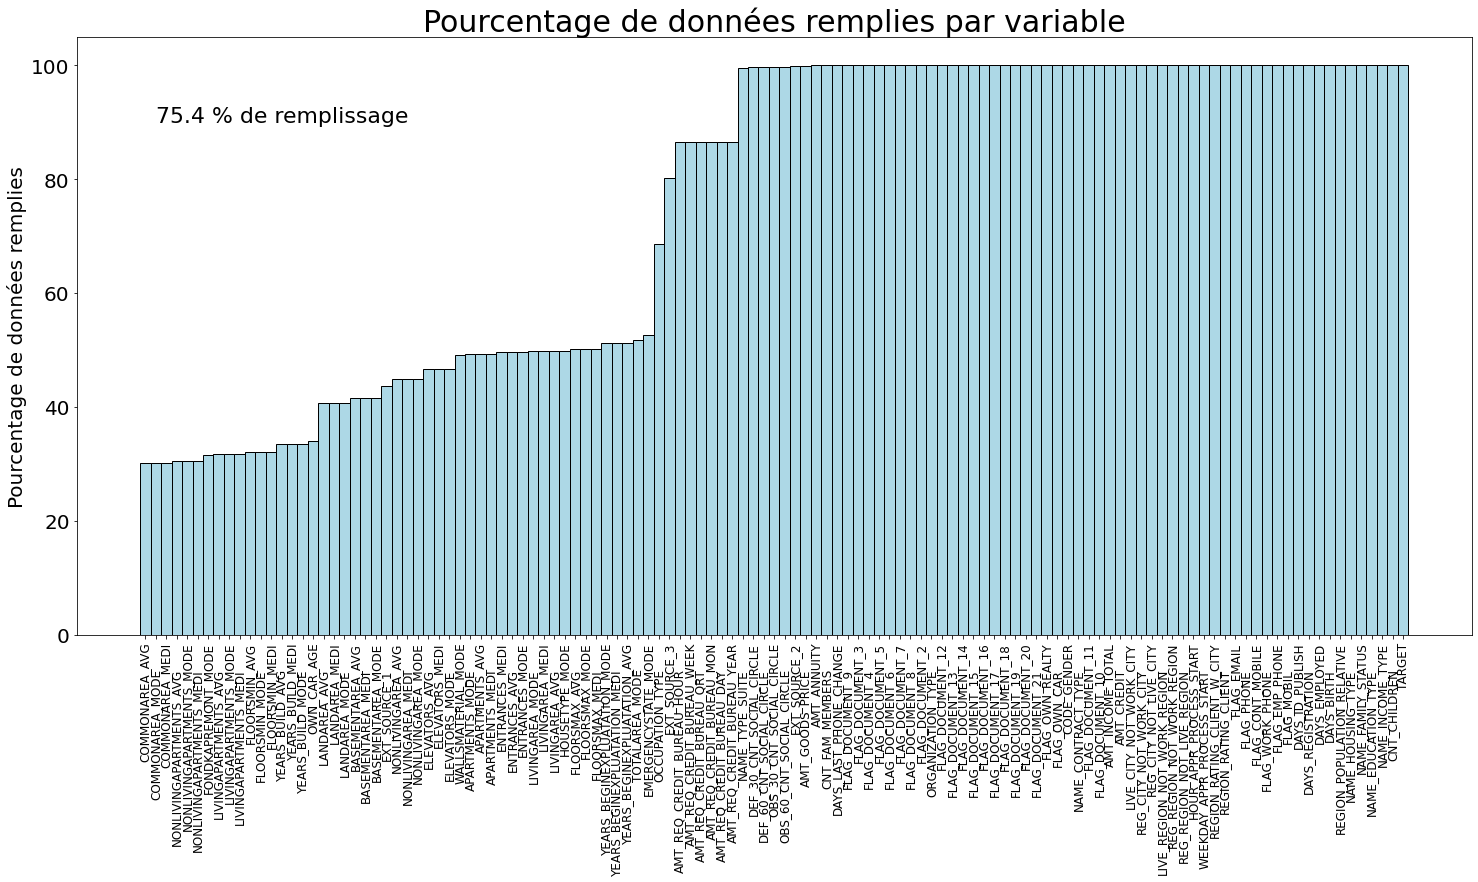

% de remplissage des colonnes : 75.40243873826618


In [14]:
remplissage(df_train,titl="_AVANT")

### Correlations entre les variables :

Beaucoup des variables correlées le sont parce qu'elles sont majoritairement composées de NaN.

/tmp/ipykernel_123873/4184119961.py:13: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = df_train_c.corr()


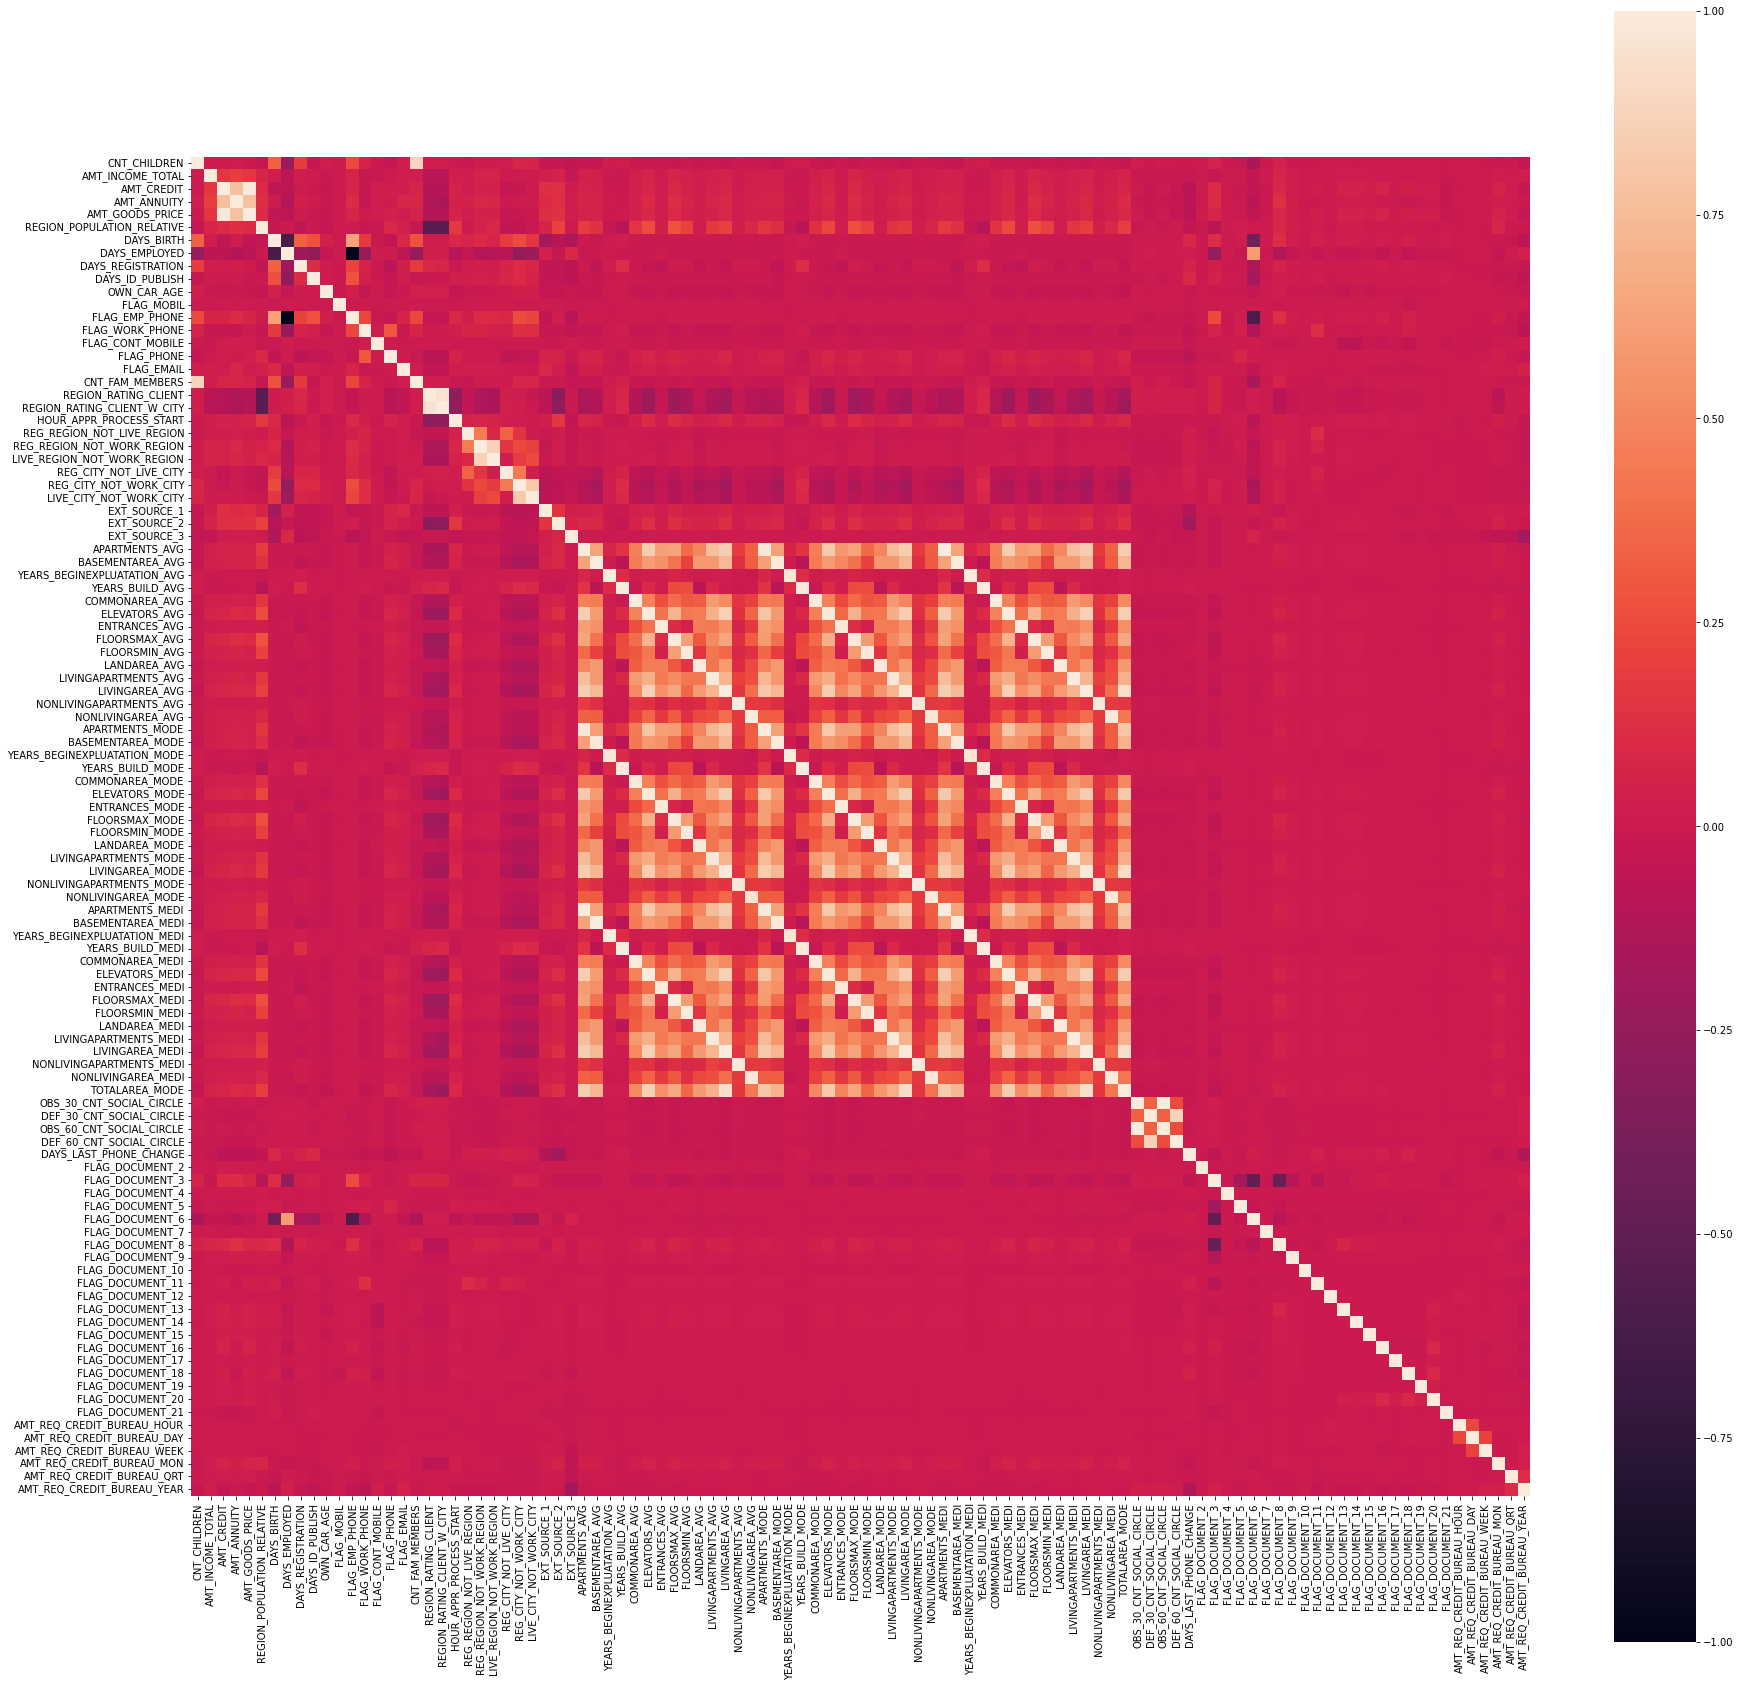

In [15]:

df_train_c = df_train.drop(columns='TARGET').copy()
# copie pour correlations

categorical = df_train_c.loc[:, df_train_c.dtypes == 'object'].columns.tolist()
continuous = df_train_c.loc[:, df_train_c.dtypes != 'object'].columns.tolist()

for cat in categorical:
    df_train_c[cat].fillna(df_train_c[cat].mode()[0], inplace=True)

for cont in continuous:
    df_train_c[cont].fillna(df_train_c[cont].mode()[0], inplace=True)

df_corr = df_train_c.corr()
plt.figure(figsize=(30, 30))
sns.heatmap(df_corr, square=True, vmin=-1, vmax=1)
plt.show()

In [16]:
a=len(continuous)
print('nombre de paires de variables continues :',a*(a-1)/2)

nombre de paires de variables continues : 5356.0


In [17]:
df=df_corr.copy()

df_out = df.stack().loc[lambda x: x.index.get_level_values(0) < x.index.get_level_values(1)]
df_out.index = df_out.index.map(' X '.join)
df_out = df_out.to_frame().T

print('vérification que le nombre de paires uniques de var. continues est bon :',df_out.shape[1])

vérification que le nombre de paires uniques de var. continues est bon : 5356


In [18]:
# sélection des paires avec correlation supp à 0.6 ou inférieur à 0.6 et suppression de ces variables
paires = df_out.loc[
    0, ((df_out.loc[0, df_out.columns.tolist()].values > 0.6)
    | (df_out.loc[0, df_out.columns.tolist()].values < -0.6))].index.tolist()

uniq = []
for paire in paires:
    a = paire.split(' X ')[0]
    b = paire.split(' X ')[1]
    uniq.append(a)
    uniq.append(b)
uniq = set(uniq)
len(uniq)

del df_out

(307511, 59)


/tmp/ipykernel_123873/3856046021.py:14: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = df_train_c.corr()


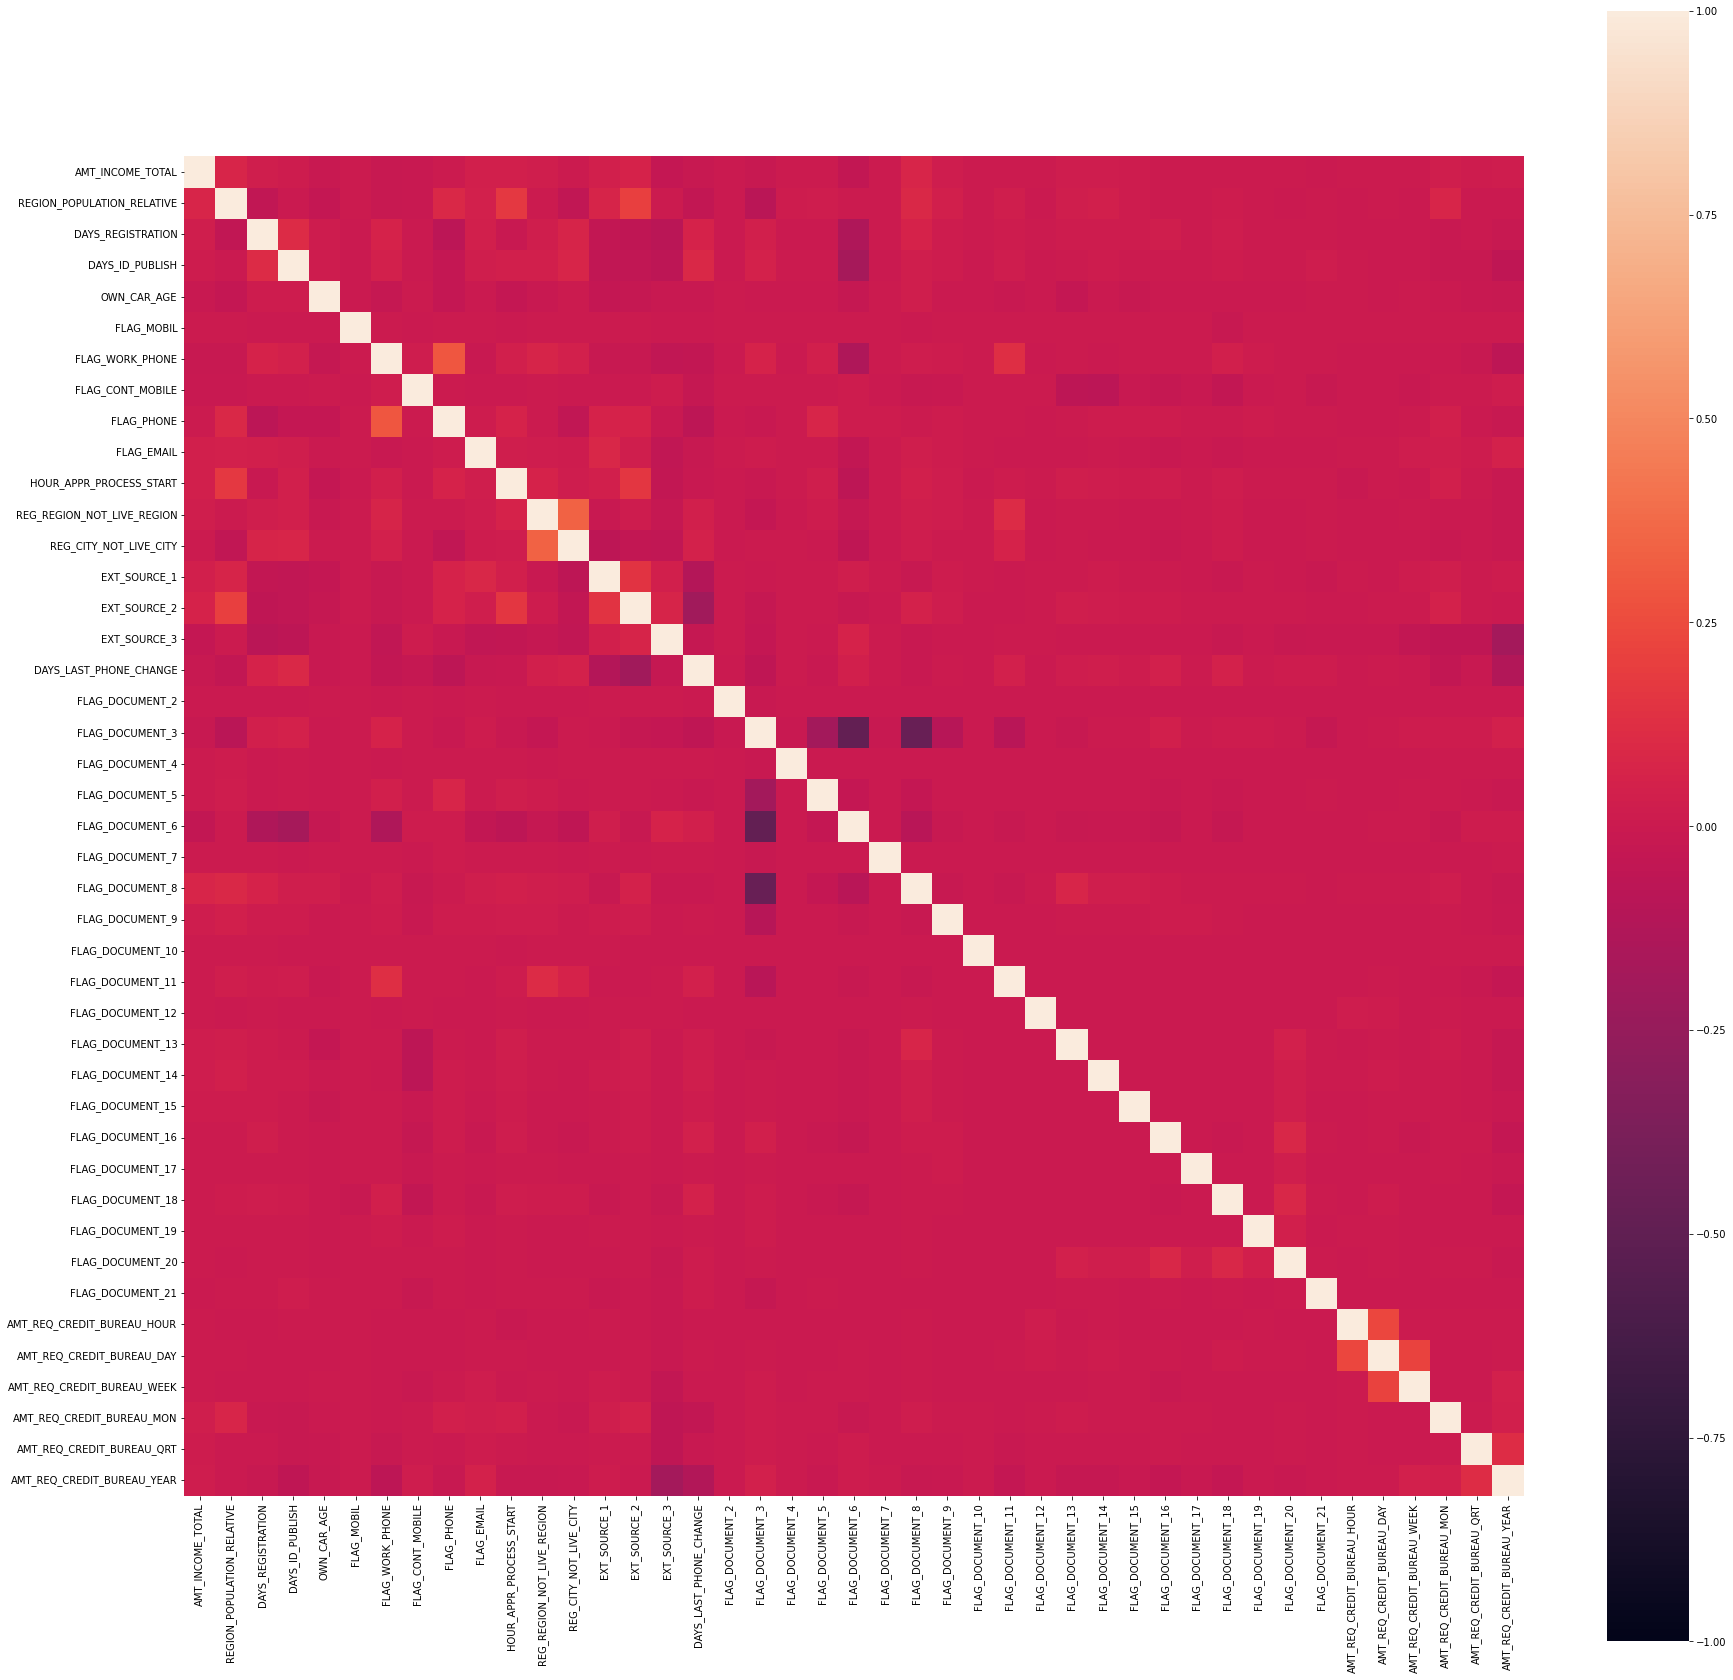

In [19]:
# Plot des variables restantes
df_train_c = df_train.drop(columns='TARGET').copy()
df_train_c.drop(columns=uniq, inplace=True)
print(df_train_c.shape)

categorical = df_train_c.loc[:, df_train_c.dtypes == 'object'].columns.tolist()
continuous = df_train_c.loc[:, df_train_c.dtypes != 'object'].columns.tolist()

for cat in categorical:
    df_train_c[cat].fillna(df_train_c[cat].mode()[0], inplace=True)

for cont in continuous:
    df_train_c[cont].fillna(df_train_c[cont].mode()[0], inplace=True)

df_corr = df_train_c.corr()
plt.figure(figsize=(30, 30))
sns.heatmap(df_corr, square=True, vmin=-1, vmax=1)
plt.show()

In [20]:
df_corr.min().sort_values()

FLAG_DOCUMENT_6              -0.486238
FLAG_DOCUMENT_3              -0.486238
FLAG_DOCUMENT_8              -0.465730
DAYS_LAST_PHONE_CHANGE       -0.195684
EXT_SOURCE_2                 -0.195684
FLAG_DOCUMENT_5              -0.193850
EXT_SOURCE_3                 -0.186129
AMT_REQ_CREDIT_BUREAU_YEAR   -0.186129
DAYS_ID_PUBLISH              -0.178282
FLAG_WORK_PHONE              -0.138345
DAYS_REGISTRATION            -0.137769
EXT_SOURCE_1                 -0.109438
FLAG_DOCUMENT_9              -0.097859
FLAG_DOCUMENT_11             -0.093242
REGION_POPULATION_RELATIVE   -0.084644
FLAG_PHONE                   -0.075188
FLAG_DOCUMENT_14             -0.072839
FLAG_CONT_MOBILE             -0.072839
REG_CITY_NOT_LIVE_CITY       -0.069748
HOUR_APPR_PROCESS_START      -0.069582
FLAG_DOCUMENT_13             -0.064800
AMT_REQ_CREDIT_BUREAU_QRT    -0.059515
AMT_REQ_CREDIT_BUREAU_MON    -0.056176
FLAG_EMAIL                   -0.048531
AMT_INCOME_TOTAL             -0.045878
FLAG_DOCUMENT_18         

In [21]:
a=df_train_c.columns.tolist()
a.append('TARGET')
a

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'AMT_INCOME_TOTAL',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG

In [22]:
df_train=df_train[a]
print(df_train.shape)

# remplissage(df_train,titl="_APRES_CORREL")

(307511, 60)


(307511, 60)


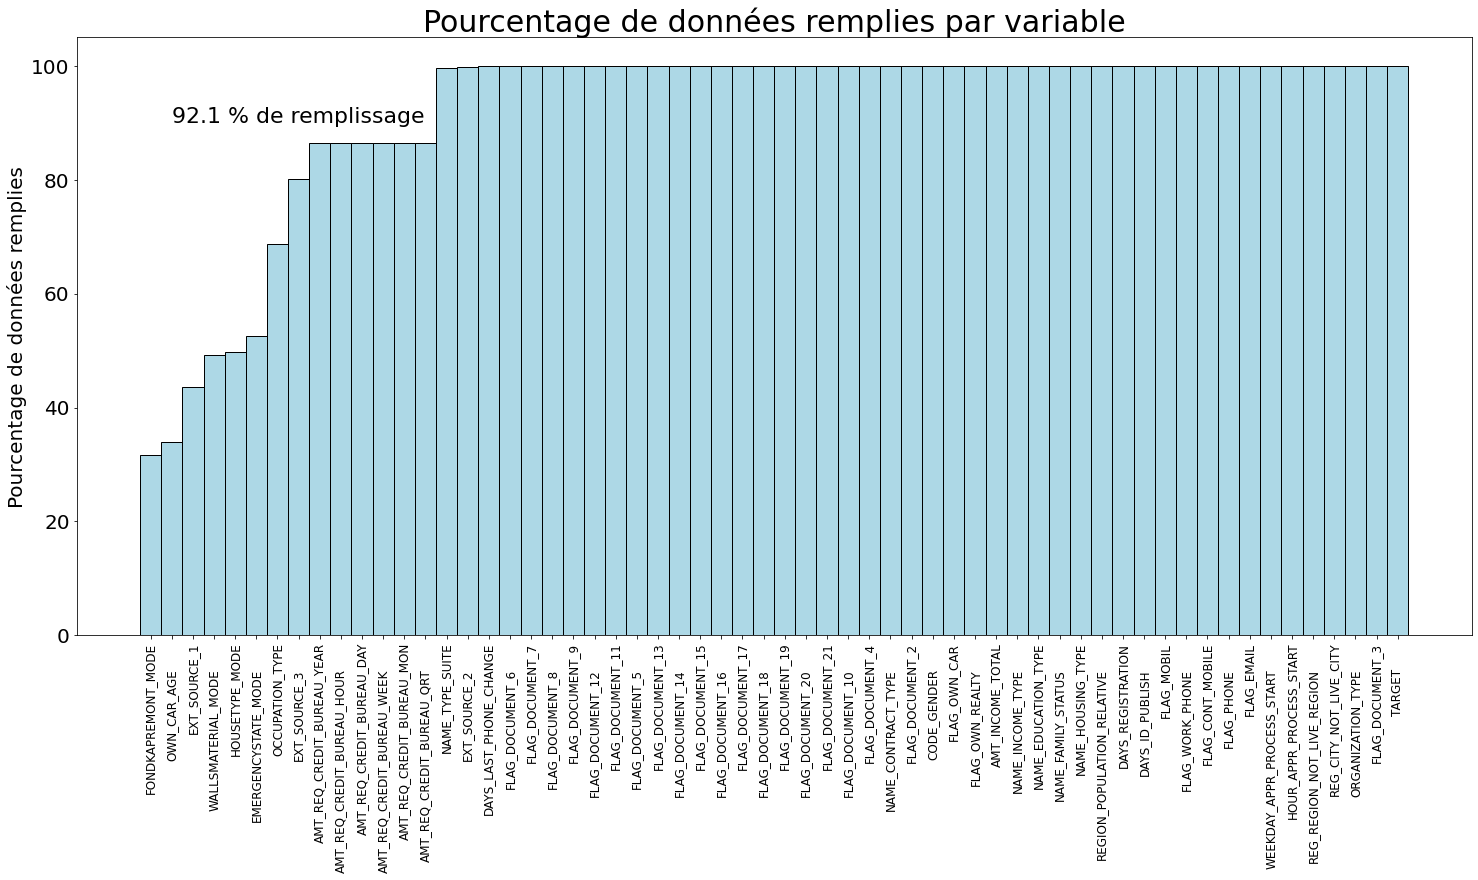

% de remplissage des colonnes : 92.13351717499536
(307511, 55)


/tmp/ipykernel_123873/1324629321.py:21: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = df_train_c.corr()


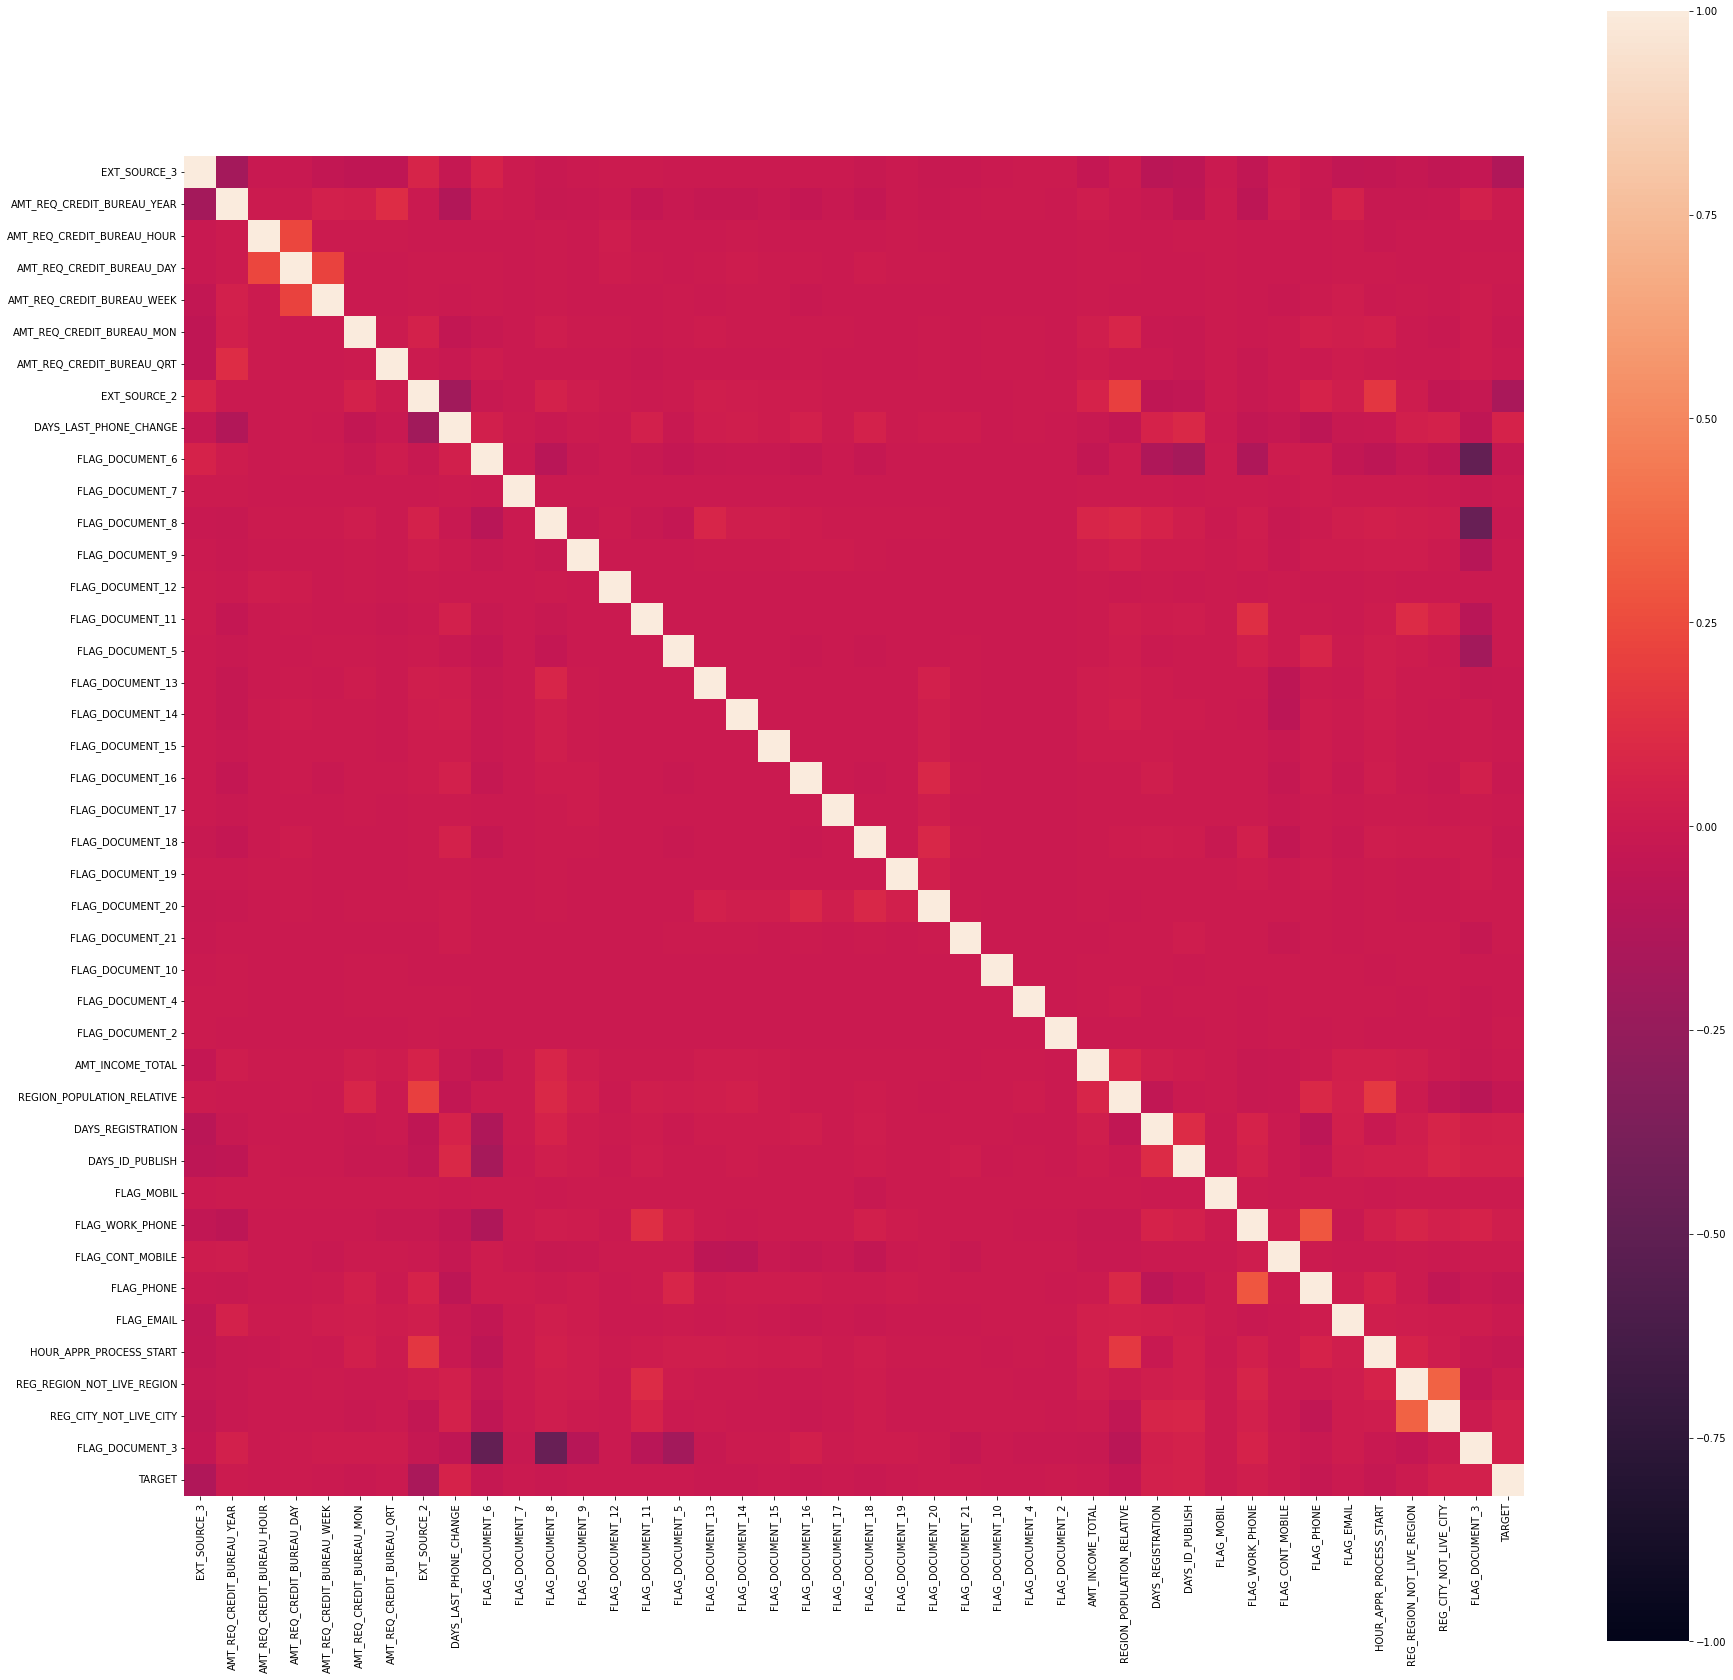

In [23]:
# on enlève les variables à moins de 50% de remplissage puis on refait la correlation
print(df_train.shape)

to_keep=remplissage(df_train,"_APRES_CORREL",seuil=50)

df_train=df_train[to_keep]
print(df_train.shape)

df_train_c = df_train.copy()
# copie pour correlations

categorical = df_train.loc[:, df_train.dtypes == 'object'].columns.tolist()
continuous = df_train.loc[:, df_train.dtypes != 'object'].columns.tolist()

for cat in categorical:
    df_train_c[cat].fillna(df_train_c[cat].mode()[0], inplace=True)

for cont in continuous:
    df_train_c[cont].fillna(df_train_c[cont].mode()[0], inplace=True)

df_corr = df_train_c.corr()
plt.figure(figsize=(30, 30))
sns.heatmap(df_corr, square=True, vmin=-1, vmax=1)
plt.show()

(307511, 55)


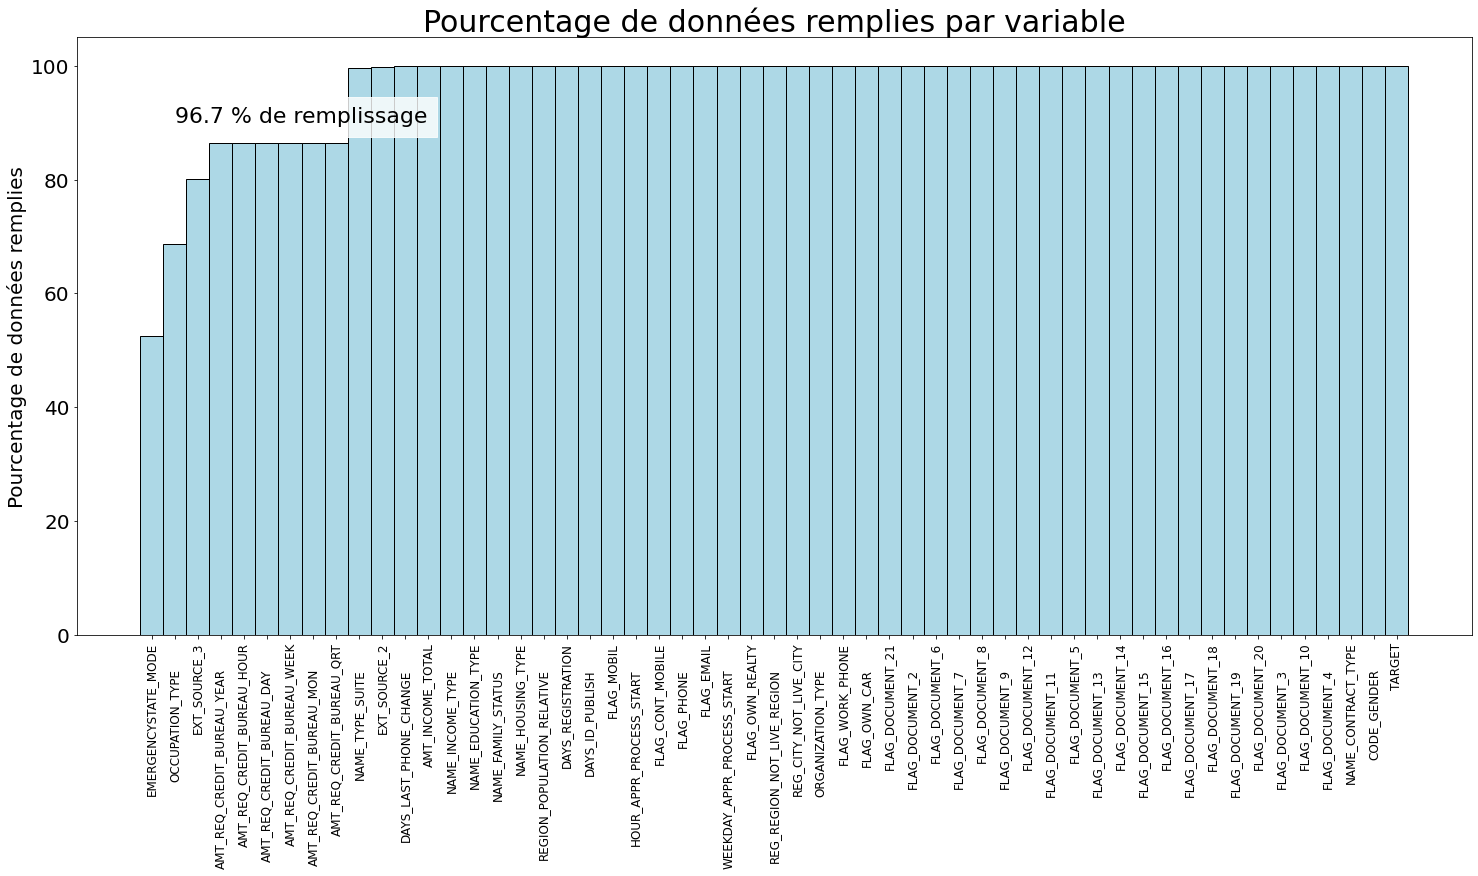

% de remplissage des colonnes : 96.72338107047759


In [24]:
# Remplissage une fois ces variables supprimées
print(df_train.shape)
remplissage(df_train,titl="_APRES_REMPLI")

In [25]:
X=df_train.drop(columns='TARGET').values
y=df_train['TARGET'].values

from collections import Counter
Counter(y)

Counter({1: 24825, 0: 282686})

In [26]:
df_train.head()

,EMERGENCYSTATE_MODE,OCCUPATION_TYPE,EXT_SOURCE_3,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,NAME_TYPE_SUITE,...,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_CITY_NOT_LIVE_CITY,ORGANIZATION_TYPE,FLAG_DOCUMENT_3,TARGET
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,No,Laborers,0.139376,1.0,0.0,0.0,0.0,0.0,0.0,Unaccompanied,...,1,1,0,WEDNESDAY,10,0,0,Business Entity Type 3,1,1
100003,No,Core staff,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Family,...,1,1,0,MONDAY,11,0,0,School,1,0
100004,NaN,Laborers,0.729567,0.0,0.0,0.0,0.0,0.0,0.0,Unaccompanied,...,1,1,0,MONDAY,9,0,0,Government,0,0
100006,NaN,Laborers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unaccompanied,...,1,0,0,WEDNESDAY,17,0,0,Business Entity Type 3,1,0
100007,NaN,Core staff,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Unaccompanied,...,1,0,0,THURSDAY,11,0,0,Religion,0,0


In [29]:
df_train_balanced=smotenc(df_train)
del df_train

print("taille finale de la df",df_train_balanced.shape)

X=df_train_balanced.drop(columns='TARGET').values
y=df_train_balanced['TARGET'].values

from collections import Counter
Counter(y)

verif nbe de nan apres remplacement :  0
Application du SMOTE-NC
Application de l'undersampling
Creation DataFrame des individus finaux
taille finale de la df (56536, 55)


Counter({0: 28268, 1: 28268})

In [30]:
df_train_balanced.head()

,EMERGENCYSTATE_MODE,OCCUPATION_TYPE,EXT_SOURCE_3,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,NAME_TYPE_SUITE,...,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_CITY_NOT_LIVE_CITY,ORGANIZATION_TYPE,FLAG_DOCUMENT_3,TARGET
0,NaN,NaN,0.609276,2.0,0.0,0.0,0.0,0.0,0.0,Unaccompanied,...,1.0,1.0,0.0,FRIDAY,10.0,0.0,0.0,XNA,0.0,0
1,NaN,NaN,0.659406,1.0,0.0,0.0,0.0,1.0,1.0,Family,...,1.0,1.0,0.0,TUESDAY,13.0,0.0,0.0,XNA,1.0,0
2,NaN,Laborers,NaN,3.0,0.0,0.0,0.0,0.0,0.0,Unaccompanied,...,1.0,0.0,0.0,THURSDAY,10.0,0.0,0.0,Self-employed,1.0,0
3,NaN,NaN,0.735221,2.0,0.0,0.0,0.0,0.0,0.0,Unaccompanied,...,1.0,0.0,0.0,THURSDAY,13.0,0.0,0.0,Transport: type 4,0.0,0
4,No,Core staff,0.334454,0.0,0.0,0.0,0.0,0.0,0.0,Unaccompanied,...,1.0,0.0,0.0,TUESDAY,9.0,0.0,0.0,Business Entity Type 3,1.0,0


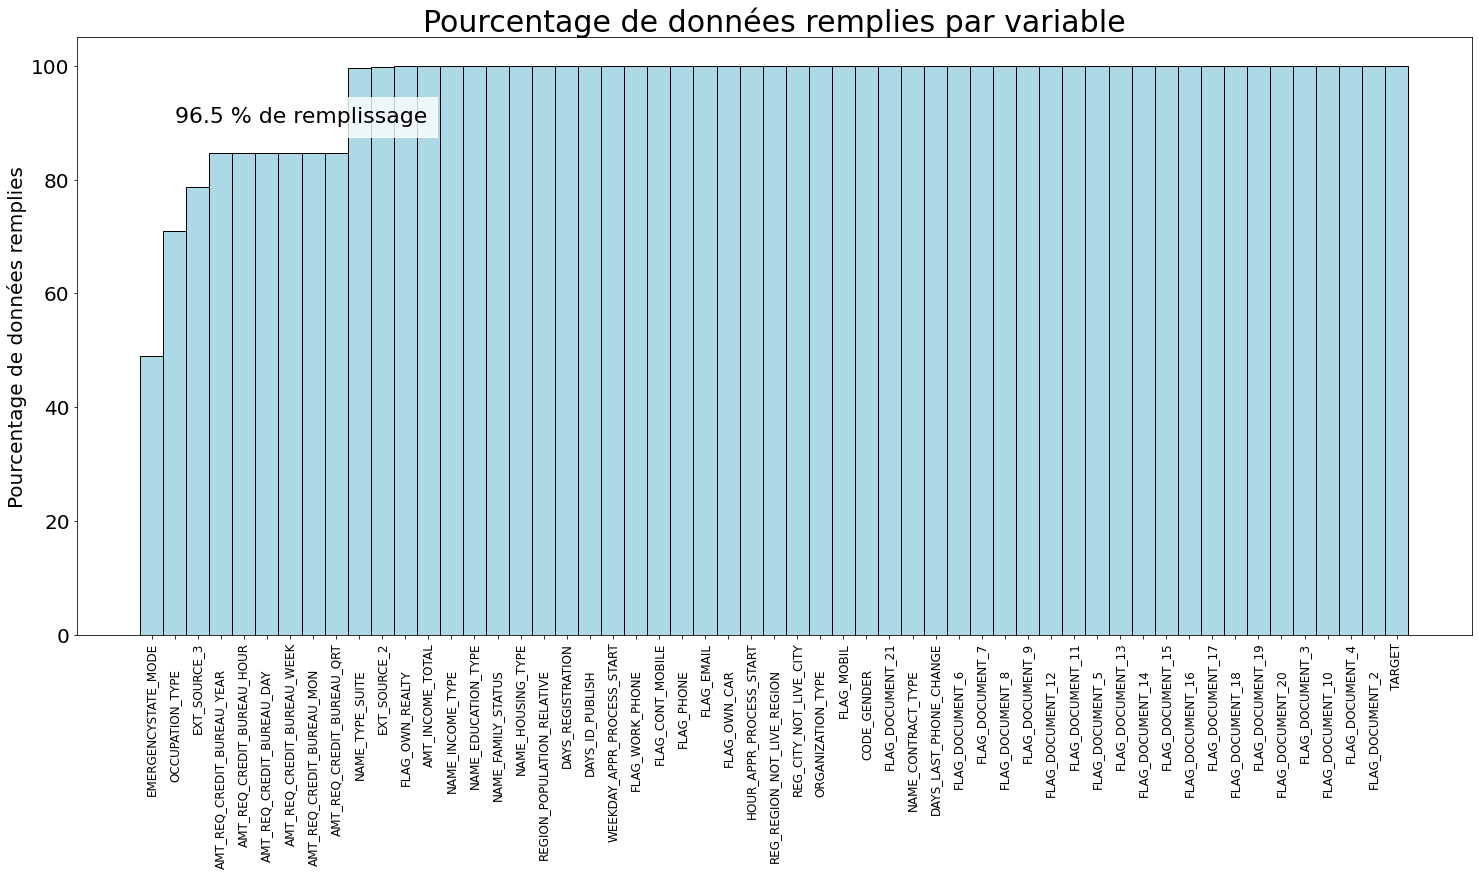

% de remplissage des colonnes : 96.47732096684976


In [32]:
remplissage(df_train_balanced,titl="_FINAL_DATASET")

In [33]:
col_train=df_train_balanced.drop(columns='TARGET').columns

df_test=pd.read_csv('./p7_datas/application_test.csv',sep=',')[col_train]
print(df_train_balanced.shape)
print(df_test.shape)

(56536, 55)
(48744, 54)


In [1]:
# Fonctions d'un kernel kaggle

def kfold_lightgbm(df, num_folds, stratified=False, debug=False):
    # Divide in training/validation and test data
    
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(
        train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds,
                                shuffle=True,
                                random_state=1001)
    else:
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [
        f for f in train_df.columns if f not in
        ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']
    ]

    for n_fold, (train_idx, valid_idx) in enumerate(
            folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df[
            'TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df[
            'TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1,
        )

        clf.fit(train_x,
                train_y,
                eval_set=[(train_x, train_y), (valid_x, valid_y)],
                eval_metric='auc',
                verbose=200,
                early_stopping_rounds=200)

        oof_preds[valid_idx] = clf.predict_proba(
            valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(
            test_df[feats],
            num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat(
            [feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' %
              (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['TARGET']].to_csv('light_gbm.csv',
                                                 index=False)
    display_importances(feature_importance_df)
    return feature_importance_df


# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[[
        "feature", "importance"
    ]].groupby("feature").mean().sort_values(by="importance",
                                             ascending=False)[:40].index
    best_features = feature_importance_df_.loc[
        feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance",
                y="feature",
                data=best_features.sort_values(by="importance",
                                               ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')


def application_train(df, num_rows=None, nan_as_category=False):
    
    print('original shape:', df.shape)
    
    df = df[df['CODE_GENDER'] != 'XNA']

    # Categorical features with Binary encode (0 or 1; two categories)
    # Categorical features are processed separately than continuous features in some steps like normalization
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    # df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

    # Some simple new features (percentages)
    #df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    # df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    # df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    # df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    # df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

    print("shape df after encoding:", df.shape)
    df_cat = df[cat_cols]
    
    df_cont = df.loc[:, ~df.columns.isin(cat_cols)].drop(columns='TARGET')
    tgt=df['TARGET']
    
    scaler = RobustScaler()

    col_cont = df_cont.columns
    scaled = scaler.fit_transform(df_cont.values)
    scaled = pd.DataFrame(scaled, columns=col_cont)
    # scaled = valeurs de df_cont scale
    # df_cont n'a pas été scale
    
    col_cont=df_cont.columns

    print()
    print("shape df_cat: ", df_cat.shape)
    print("shape df_cont:", df_cont.shape)
    print("df_cont scaled: ", scaled.shape)
    print()
    
    df = scaled.join(df_cat).join(tgt)

    print("df finale", df.shape)

    gc.collect()
    
    return (df, df_cont, df_cat)

def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [
        col for col in df.columns if df[col].dtype == 'object'
    ]
    print("COLS", categorical_columns)
    print()
    print('OHE - nbr de categorical avant encoding:', len(categorical_columns))
    df = pd.get_dummies(df,
                        columns=categorical_columns,
                        dummy_na=nan_as_category)

    new_columns = [c for c in df.columns if c not in original_columns]
    print('OHE - nbr de categorical après encoding:', len(new_columns))
    return df, new_columns

In [35]:
print("train balanced:",df_train_balanced.shape," - test:",df_test.shape)
print("total : ",df_train_balanced.shape[0]+df_test.shape[0])

df_train_test_balanced=pd.concat([df_train_balanced,df_test]).reset_index(drop=True)
df_train_test_balanced

train balanced: (56536, 55)  - test: (48744, 54)
total :  105280


,EMERGENCYSTATE_MODE,OCCUPATION_TYPE,EXT_SOURCE_3,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,NAME_TYPE_SUITE,...,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_CITY_NOT_LIVE_CITY,ORGANIZATION_TYPE,FLAG_DOCUMENT_3,TARGET
0,NaN,NaN,0.609276,2.0,0.0,0.0,0.0,0.0,0.0,Unaccompanied,...,1.0,1.0,0.0,FRIDAY,10.0,0.0,0.0,XNA,0.0,0.0
1,NaN,NaN,0.659406,1.0,0.0,0.0,0.0,1.0,1.0,Family,...,1.0,1.0,0.0,TUESDAY,13.0,0.0,0.0,XNA,1.0,0.0
2,NaN,Laborers,NaN,3.0,0.0,0.0,0.0,0.0,0.0,Unaccompanied,...,1.0,0.0,0.0,THURSDAY,10.0,0.0,0.0,Self-employed,1.0,0.0
3,NaN,NaN,0.735221,2.0,0.0,0.0,0.0,0.0,0.0,Unaccompanied,...,1.0,0.0,0.0,THURSDAY,13.0,0.0,0.0,Transport: type 4,0.0,0.0
4,No,Core staff,0.334454,0.0,0.0,0.0,0.0,0.0,0.0,Unaccompanied,...,1.0,0.0,0.0,TUESDAY,9.0,0.0,0.0,Business Entity Type 3,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105275,NaN,NaN,0.643026,1.0,0.0,0.0,0.0,0.0,0.0,Unaccompanied,...,1.0,1.0,0.0,WEDNESDAY,16.0,0.0,0.0,Other,0.0,NaN
105276,NaN,Sales staff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unaccompanied,...,1.0,0.0,0.0,MONDAY,11.0,0.0,0.0,Trade: type 7,1.0,NaN
105277,No,NaN,0.283712,1.0,0.0,0.0,0.0,0.0,3.0,Unaccompanied,...,1.0,1.0,0.0,WEDNESDAY,12.0,0.0,0.0,Business Entity Type 3,1.0,NaN
105278,No,Managers,0.595456,2.0,0.0,0.0,0.0,0.0,0.0,Family,...,1.0,1.0,0.0,MONDAY,10.0,0.0,0.0,Self-employed,1.0,NaN


In [37]:
# feature engineering / feature importance à partir des fonctions du kernel Kaggle

debug = False
df_train_test_balanced_encoded, df_cont, df_cat = application_train(df_train_test_balanced,
                                                   num_rows=None,
                                                   nan_as_category=False)
df_train_test_balanced_encoded = df_train_test_balanced_encoded.rename(
    columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

original shape: (105280, 55)
COLS ['EMERGENCYSTATE_MODE', 'OCCUPATION_TYPE', 'NAME_TYPE_SUITE', 'NAME_CONTRACT_TYPE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']

OHE - nbr de categorical avant encoding: 10
OHE - nbr de categorical après encoding: 118
shape df after encoding: (105280, 163)

shape df_cat:  (105280, 118)
shape df_cont: (105280, 44)
df_cont scaled:  (105280, 44)

df finale (105280, 163)


In [38]:
print(df_train_test_balanced_encoded.shape)
print(df_train_test_balanced_encoded.dropna().shape)

(105280, 163)
(44385, 163)


Starting LightGBM. Train shape: (56536, 163), test shape: (48744, 163)
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


/home/camille/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/camille/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/camille/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and w

[200]	training's auc: 0.777537	training's binary_logloss: 0.568774	valid_1's auc: 0.767122	valid_1's binary_logloss: 0.576697
[400]	training's auc: 0.793929	training's binary_logloss: 0.549339	valid_1's auc: 0.773308	valid_1's binary_logloss: 0.567026
[600]	training's auc: 0.805659	training's binary_logloss: 0.537198	valid_1's auc: 0.774152	valid_1's binary_logloss: 0.565063
[800]	training's auc: 0.815938	training's binary_logloss: 0.526895	valid_1's auc: 0.774139	valid_1's binary_logloss: 0.564452
Fold  1 AUC : 0.774350
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


/home/camille/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/camille/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/camille/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and w

[200]	training's auc: 0.777802	training's binary_logloss: 0.568253	valid_1's auc: 0.763063	valid_1's binary_logloss: 0.579526
[400]	training's auc: 0.794487	training's binary_logloss: 0.548645	valid_1's auc: 0.769285	valid_1's binary_logloss: 0.570302
[600]	training's auc: 0.806297	training's binary_logloss: 0.536478	valid_1's auc: 0.770582	valid_1's binary_logloss: 0.567833
[800]	training's auc: 0.81666	training's binary_logloss: 0.526058	valid_1's auc: 0.770551	valid_1's binary_logloss: 0.567108
Fold  2 AUC : 0.770701
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


/home/camille/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/camille/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/camille/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and w

[200]	training's auc: 0.777855	training's binary_logloss: 0.568468	valid_1's auc: 0.76699	valid_1's binary_logloss: 0.577643
[400]	training's auc: 0.794634	training's binary_logloss: 0.548191	valid_1's auc: 0.772037	valid_1's binary_logloss: 0.569408
[600]	training's auc: 0.805547	training's binary_logloss: 0.536918	valid_1's auc: 0.772782	valid_1's binary_logloss: 0.567994
Fold  3 AUC : 0.772786
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


/home/camille/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/camille/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/camille/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and w

[200]	training's auc: 0.778056	training's binary_logloss: 0.56809	valid_1's auc: 0.758328	valid_1's binary_logloss: 0.583372
[400]	training's auc: 0.794303	training's binary_logloss: 0.548712	valid_1's auc: 0.765036	valid_1's binary_logloss: 0.574135
[600]	training's auc: 0.806068	training's binary_logloss: 0.536608	valid_1's auc: 0.766467	valid_1's binary_logloss: 0.572111
[800]	training's auc: 0.816607	training's binary_logloss: 0.526309	valid_1's auc: 0.766399	valid_1's binary_logloss: 0.572003
Fold  4 AUC : 0.766768
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


/home/camille/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/camille/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/camille/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and w

[200]	training's auc: 0.779586	training's binary_logloss: 0.566571	valid_1's auc: 0.750062	valid_1's binary_logloss: 0.589968
[400]	training's auc: 0.795997	training's binary_logloss: 0.546931	valid_1's auc: 0.755687	valid_1's binary_logloss: 0.582335
[600]	training's auc: 0.807429	training's binary_logloss: 0.534948	valid_1's auc: 0.757242	valid_1's binary_logloss: 0.580219
Fold  5 AUC : 0.757308
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


/home/camille/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/camille/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/camille/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and w

[200]	training's auc: 0.779292	training's binary_logloss: 0.56718	valid_1's auc: 0.752643	valid_1's binary_logloss: 0.587292
[400]	training's auc: 0.796289	training's binary_logloss: 0.547023	valid_1's auc: 0.756617	valid_1's binary_logloss: 0.580172
[600]	training's auc: 0.807894	training's binary_logloss: 0.534776	valid_1's auc: 0.757532	valid_1's binary_logloss: 0.578765
[800]	training's auc: 0.817791	training's binary_logloss: 0.524961	valid_1's auc: 0.75772	valid_1's binary_logloss: 0.578523
Fold  6 AUC : 0.757845
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


/home/camille/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/camille/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/camille/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and w

[200]	training's auc: 0.778757	training's binary_logloss: 0.56757	valid_1's auc: 0.75794	valid_1's binary_logloss: 0.584158
[400]	training's auc: 0.795392	training's binary_logloss: 0.547712	valid_1's auc: 0.762867	valid_1's binary_logloss: 0.576473
[600]	training's auc: 0.807016	training's binary_logloss: 0.535691	valid_1's auc: 0.76381	valid_1's binary_logloss: 0.575102
[800]	training's auc: 0.817519	training's binary_logloss: 0.525335	valid_1's auc: 0.763697	valid_1's binary_logloss: 0.575231
Fold  7 AUC : 0.763958
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


/home/camille/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/camille/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/camille/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and w

[200]	training's auc: 0.778603	training's binary_logloss: 0.567635	valid_1's auc: 0.760099	valid_1's binary_logloss: 0.581819
[400]	training's auc: 0.795547	training's binary_logloss: 0.547808	valid_1's auc: 0.766239	valid_1's binary_logloss: 0.572895
[600]	training's auc: 0.807509	training's binary_logloss: 0.535542	valid_1's auc: 0.766362	valid_1's binary_logloss: 0.571625
Fold  8 AUC : 0.766717
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


/home/camille/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/camille/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/camille/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and w

[200]	training's auc: 0.779045	training's binary_logloss: 0.567363	valid_1's auc: 0.751302	valid_1's binary_logloss: 0.589453
[400]	training's auc: 0.7957	training's binary_logloss: 0.547377	valid_1's auc: 0.758219	valid_1's binary_logloss: 0.58013
[600]	training's auc: 0.807644	training's binary_logloss: 0.534956	valid_1's auc: 0.759684	valid_1's binary_logloss: 0.577973
[800]	training's auc: 0.817672	training's binary_logloss: 0.524848	valid_1's auc: 0.759637	valid_1's binary_logloss: 0.577775
Fold  9 AUC : 0.759855
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


/home/camille/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/camille/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/camille/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and w

[200]	training's auc: 0.778373	training's binary_logloss: 0.567883	valid_1's auc: 0.759865	valid_1's binary_logloss: 0.582997
[400]	training's auc: 0.795402	training's binary_logloss: 0.547445	valid_1's auc: 0.764469	valid_1's binary_logloss: 0.575207
[600]	training's auc: 0.806802	training's binary_logloss: 0.535677	valid_1's auc: 0.764628	valid_1's binary_logloss: 0.574381
[800]	training's auc: 0.816736	training's binary_logloss: 0.525828	valid_1's auc: 0.764041	valid_1's binary_logloss: 0.574495
Fold 10 AUC : 0.764842
Full AUC score 0.765460


/tmp/ipykernel_123873/2546838150.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['TARGET'] = sub_preds


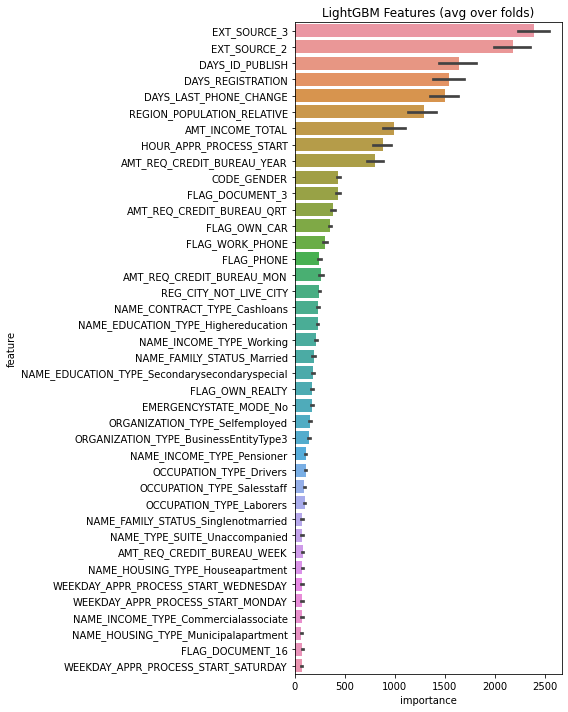

In [39]:
feat_importance = kfold_lightgbm(df_train_test_balanced_encoded,
                                 num_folds=10,
                                 stratified=False,
                                 debug=debug)

In [40]:
feat_importance.sort_values(by='importance', ascending=False)

,feature,importance,fold
0,EXT_SOURCE_3,2731,6
0,EXT_SOURCE_3,2658,1
0,EXT_SOURCE_3,2594,2
0,EXT_SOURCE_3,2500,7
7,EXT_SOURCE_2,2489,9
...,...,...,...
131,ORGANIZATION_TYPE_Insurance,0,6
59,OCCUPATION_TYPE_Realtyagents,0,5
64,NAME_TYPE_SUITE_Children,0,8
79,NAME_INCOME_TYPE_Unemployed,0,3


In [41]:
feat_importance.groupby(['feature']).mean().sort_values(by='importance', ascending=False).iloc[:30,:]

,importance,fold
feature,,
EXT_SOURCE_3,2391.4,5.5
EXT_SOURCE_2,2177.2,5.5
DAYS_ID_PUBLISH,1646.0,5.5
DAYS_REGISTRATION,1543.4,5.5
DAYS_LAST_PHONE_CHANGE,1499.6,5.5
REGION_POPULATION_RELATIVE,1296.4,5.5
AMT_INCOME_TOTAL,996.3,5.5
HOUR_APPR_PROCESS_START,877.9,5.5
AMT_REQ_CREDIT_BUREAU_YEAR,806.5,5.5


### Sélection des 10 meilleures features finales
- remplacement par imputation des valeurs manquantes
- suppression de quelques outliers
- sauvegarde

In [42]:
final_features=feat_importance.groupby(['feature']).mean().sort_values(by='importance', ascending=False).iloc[:10,:].index.tolist()
final_features.append('TARGET')

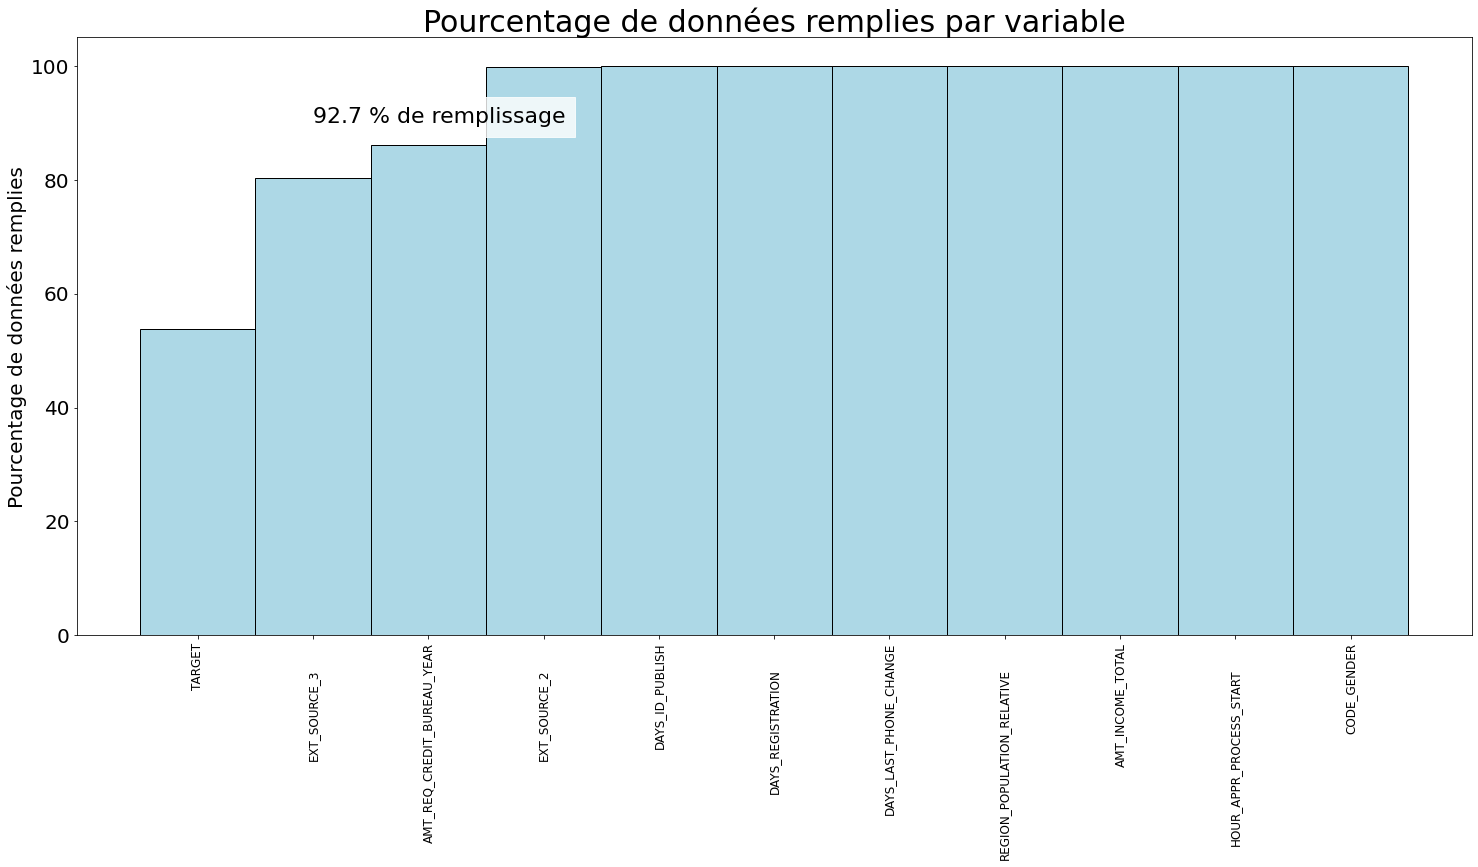

% de remplissage des colonnes : 92.71950124343742


In [43]:
remplissage(df_train_test_balanced_encoded[final_features], titl='final_df_with_TestData')

In [44]:
final_features

['EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'DAYS_ID_PUBLISH',
 'DAYS_REGISTRATION',
 'DAYS_LAST_PHONE_CHANGE',
 'REGION_POPULATION_RELATIVE',
 'AMT_INCOME_TOTAL',
 'HOUR_APPR_PROCESS_START',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'CODE_GENDER',
 'TARGET']

In [45]:
df_cont

,EXT_SOURCE_3,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,EXT_SOURCE_2,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_6,...,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_3
0,0.609276,2.0,0.0,0.0,0.0,0.0,0.0,0.588927,-1626.0,1.0,...,-1247.0,1.0,0.0,1.0,1.0,0.0,10.0,0.0,0.0,0.0
1,0.659406,1.0,0.0,0.0,0.0,1.0,1.0,0.712589,-3078.0,0.0,...,-4662.0,1.0,0.0,1.0,1.0,0.0,13.0,0.0,0.0,1.0
2,NaN,3.0,0.0,0.0,0.0,0.0,0.0,0.724572,-434.0,0.0,...,-4308.0,1.0,1.0,1.0,0.0,0.0,10.0,0.0,0.0,1.0
3,0.735221,2.0,0.0,0.0,0.0,0.0,0.0,0.588985,-295.0,0.0,...,-504.0,1.0,0.0,1.0,0.0,0.0,13.0,0.0,0.0,0.0
4,0.334454,0.0,0.0,0.0,0.0,0.0,0.0,0.750144,-2061.0,0.0,...,-3121.0,1.0,0.0,1.0,0.0,0.0,9.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105275,0.643026,1.0,0.0,0.0,0.0,0.0,0.0,0.648575,-684.0,0.0,...,-3399.0,1.0,1.0,1.0,1.0,0.0,16.0,0.0,0.0,0.0
105276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.684596,0.0,0.0,...,-3003.0,1.0,0.0,1.0,0.0,0.0,11.0,0.0,0.0,1.0
105277,0.283712,1.0,0.0,0.0,0.0,0.0,3.0,0.632770,-838.0,0.0,...,-1504.0,1.0,0.0,1.0,1.0,0.0,12.0,0.0,0.0,1.0
105278,0.595456,2.0,0.0,0.0,0.0,0.0,0.0,0.445701,-2308.0,0.0,...,-1364.0,1.0,1.0,1.0,1.0,0.0,10.0,0.0,0.0,1.0


In [46]:
# Sauvegarde des données finales : df_cat (var encodées) et de df_cont (continues, pas encodées) + TARGET 
# avec sélection des bonnes features
DF_FINALE=df_cat.join(df_cont,).join(df_train_test_balanced_encoded.TARGET)[final_features]

<AxesSubplot: >

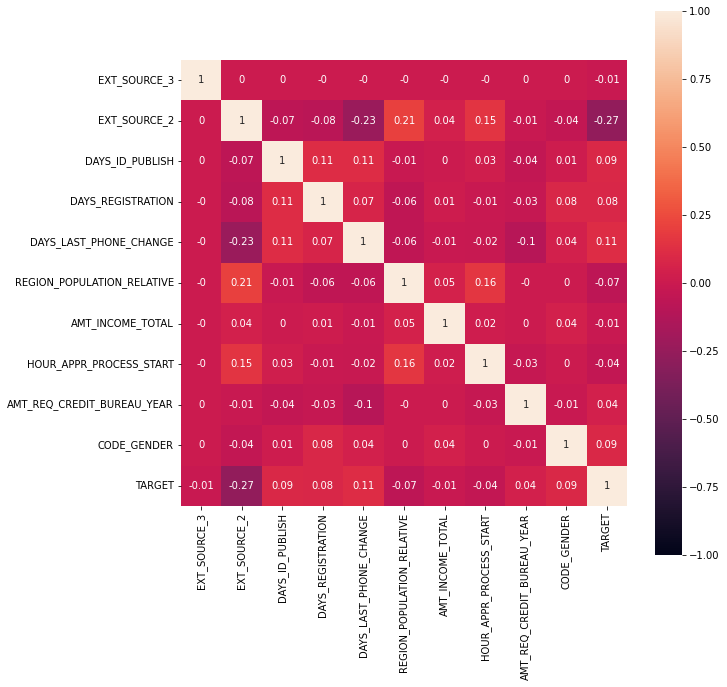

In [47]:
# Matrice de correlation final entre les features et avec la TARGET pour vérifier qu'aucune des variables
# sélectionnées ne soit trop corrélées avec la cible.

plt.figure(figsize=(10, 10))
sns.heatmap( np.round(df_train_test_balanced_encoded[final_features].corr(),2),
            vmin=-1,
            vmax=1,
            square=True,
           annot=True)
 

(105280, 11)
(56536, 11)


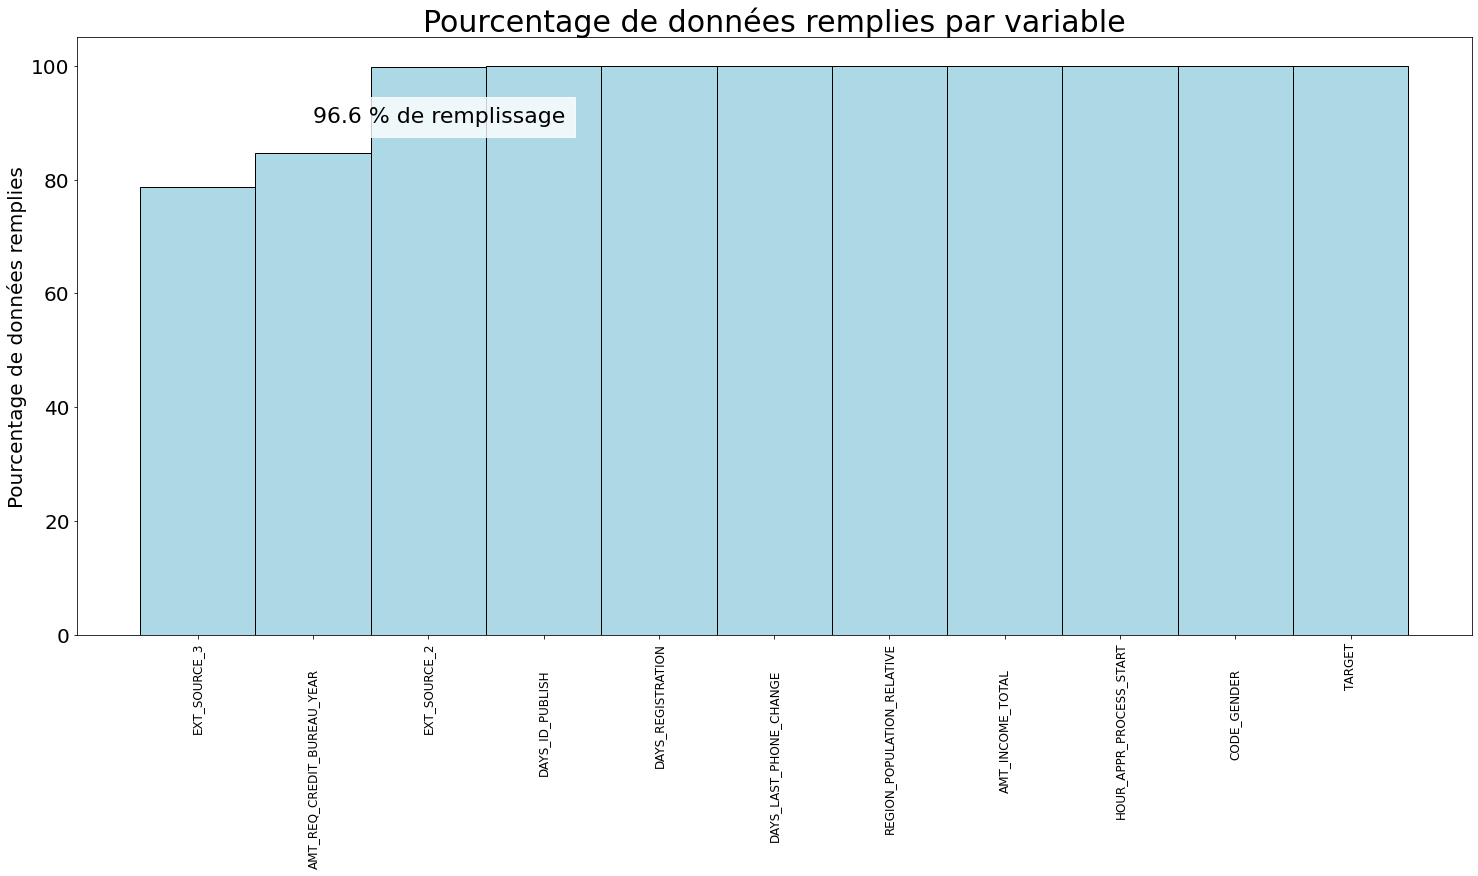

% de remplissage des colonnes : 96.64815338899108


In [149]:
df= DF_FINALE.loc[
   DF_FINALE['TARGET'].isna() == False,
    final_features]
print(DF_FINALE.shape)
print(df.shape)
remplissage(df, titl="finalDF_train")

In [132]:
pd.read_csv("final_data/df_train.csv", sep=",").drop(columns=["Unnamed: 0"]).shape

(56536, 11)

In [133]:
print(df[df['AMT_INCOME_TOTAL'] < 116000000].shape)

(56535, 11)


In [174]:
df_out['AMT_INCOME_TOTAL'].max()

13500000.0

(56533, 11)


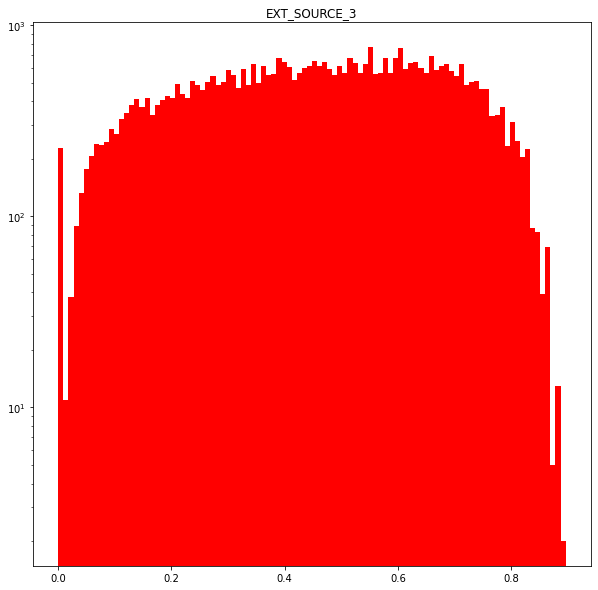

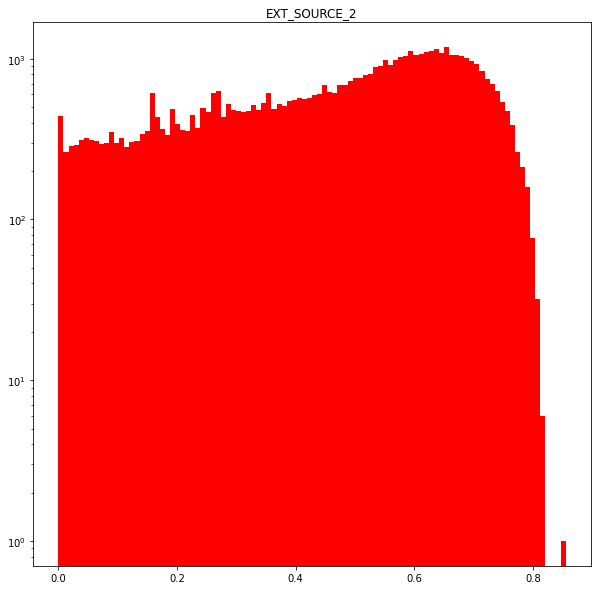

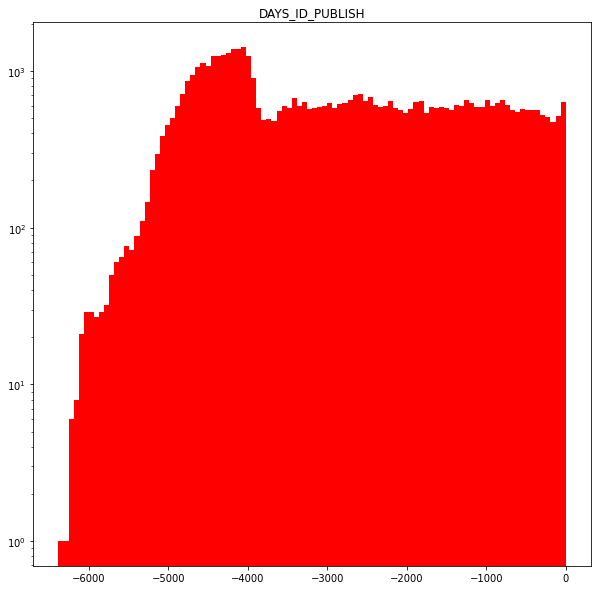

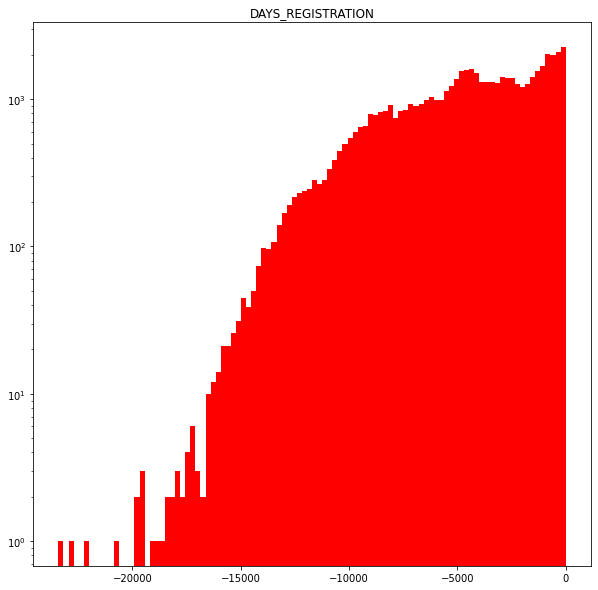

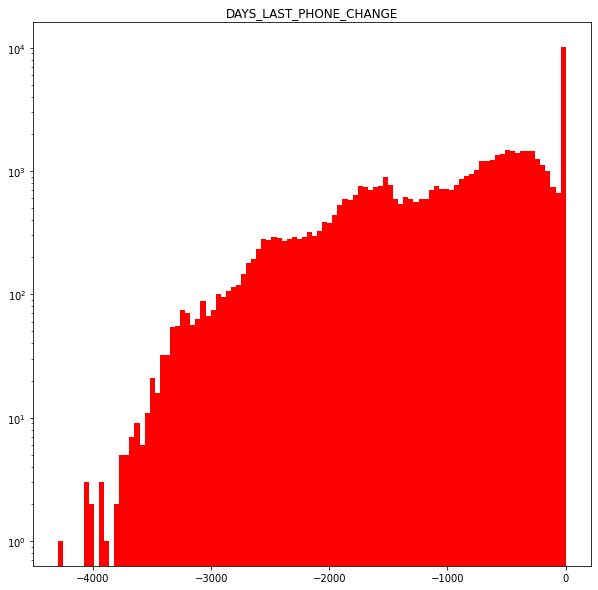

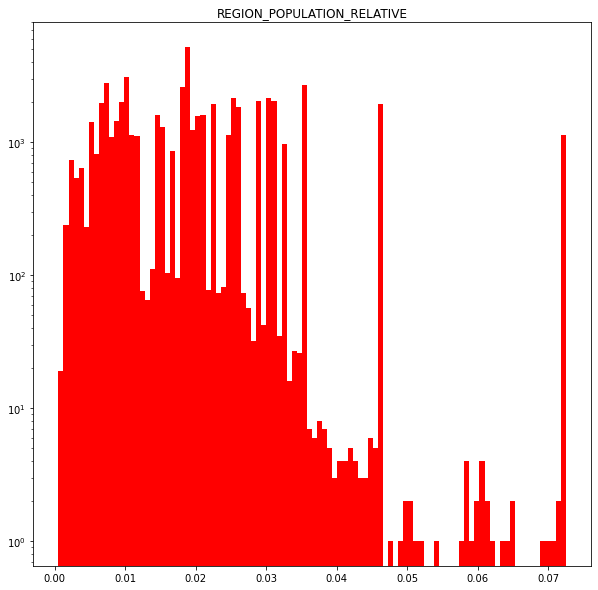

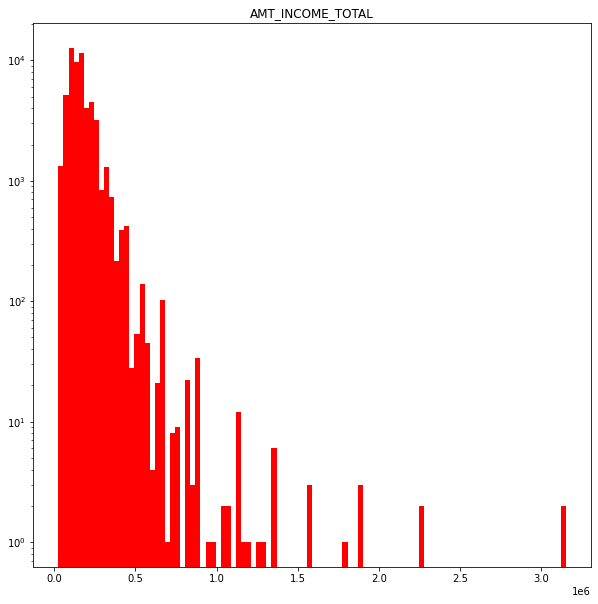

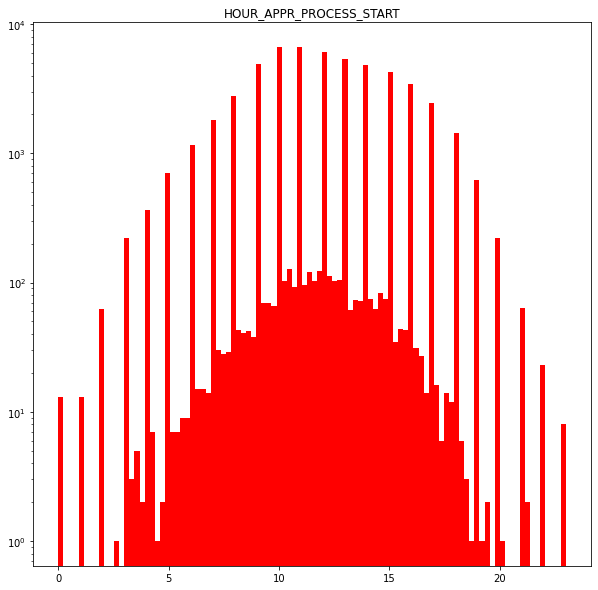

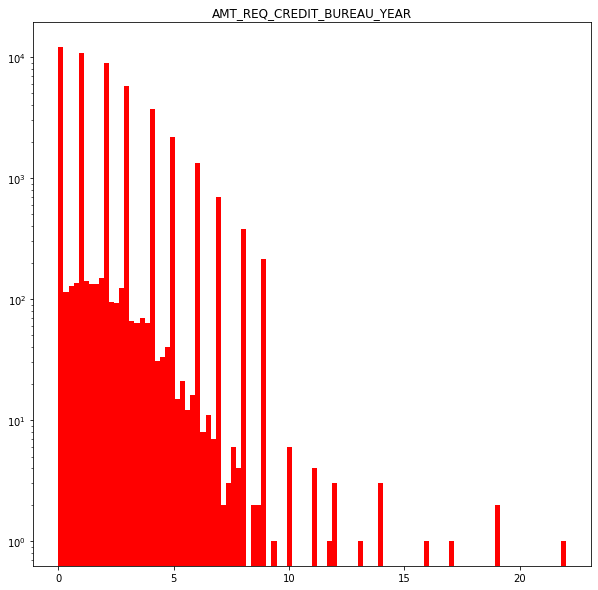

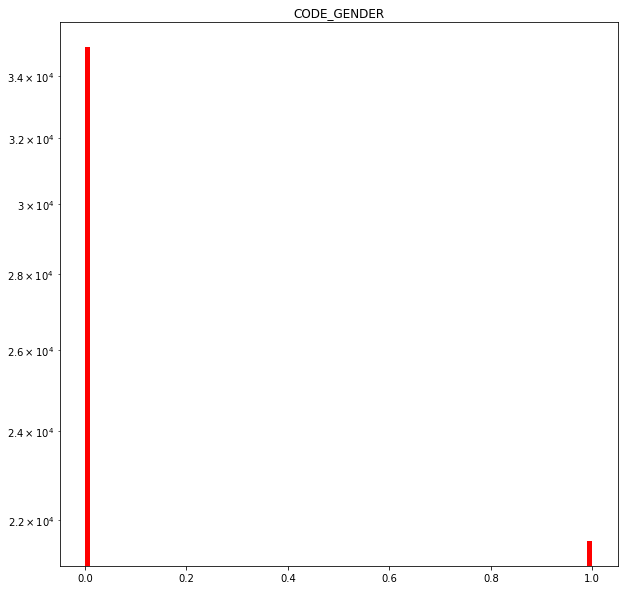

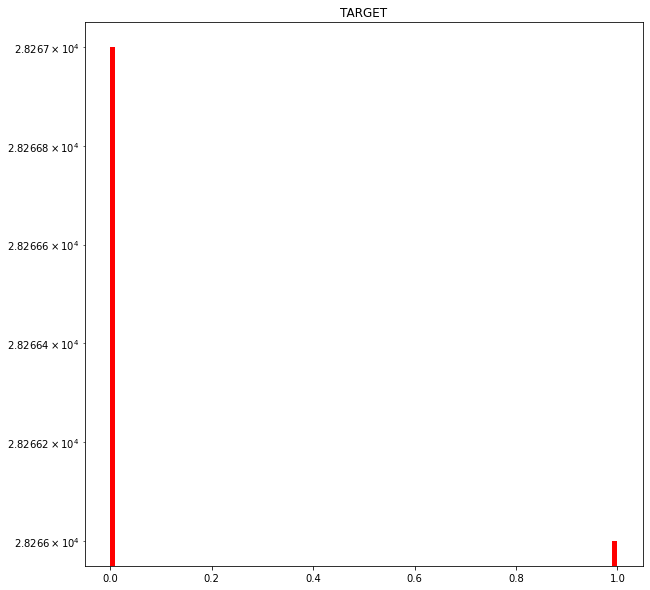

In [175]:
df_out=df.copy()
df_out = df_out[df_out['AMT_INCOME_TOTAL'] < 13500000]
df_out = df_out[(df_out['EXT_SOURCE_3'] > -63777) | (df_out['EXT_SOURCE_3'].isna()==True)]
# enlever 3 outliers en gardant les NaN
print(df_out.shape)

for col in df_out.columns:
    plt.figure(figsize=(10, 10))
    plt.hist(df_out[col], bins=100, color='red', zorder=0, log=True)
    plt.title(col)
    plt.show()
plt.close('all')

In [176]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=20, random_state=0)
imp=imp.fit(df_out.dropna())
df_imp=pd.DataFrame(imp.transform(df_out), columns=df_out.columns)
df_imp

,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_ID_PUBLISH,DAYS_REGISTRATION,DAYS_LAST_PHONE_CHANGE,REGION_POPULATION_RELATIVE,AMT_INCOME_TOTAL,HOUR_APPR_PROCESS_START,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER,TARGET
0,0.609276,0.588927,-1247.000000,-13169.000000,-1626.000000,0.007020,157500.0,10.000000,2.000000,0.0,0.0
1,0.659406,0.712589,-4662.000000,-9017.000000,-3078.000000,0.030755,135000.0,13.000000,1.000000,0.0,0.0
2,0.546602,0.724572,-4308.000000,-4306.000000,-434.000000,0.025164,180000.0,10.000000,3.000000,1.0,0.0
3,0.735221,0.588985,-504.000000,-1605.000000,-295.000000,0.024610,202500.0,13.000000,2.000000,1.0,0.0
4,0.334454,0.750144,-3121.000000,-12222.000000,-2061.000000,0.006008,157500.0,9.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
56528,0.779300,0.408514,-4808.123588,-1530.863683,-2132.636246,0.006091,112500.0,8.718638,3.155915,0.0,1.0
56529,0.529802,0.673067,-1847.538303,-10583.755829,0.000000,0.009162,67500.0,14.420190,3.369716,0.0,1.0
56530,0.533702,0.411562,-4343.443798,-2825.620578,-80.405004,0.023269,112500.0,10.362797,2.000000,0.0,1.0
56531,0.708815,0.472674,-940.700856,-9493.740244,-237.426049,0.029218,157500.0,14.685804,2.000000,1.0,1.0


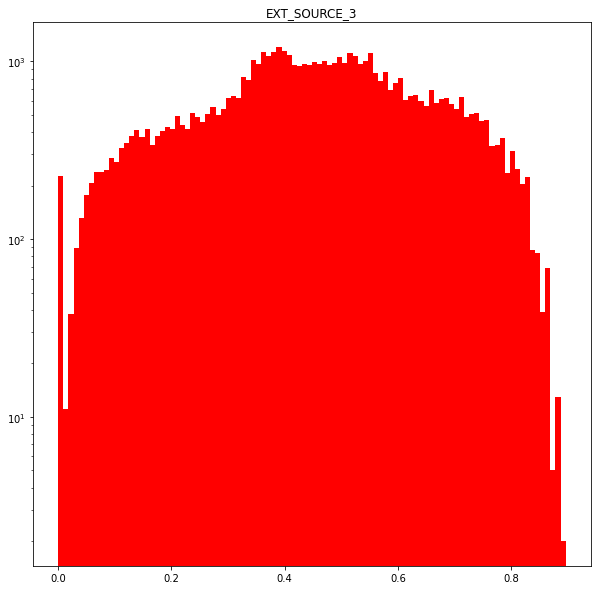

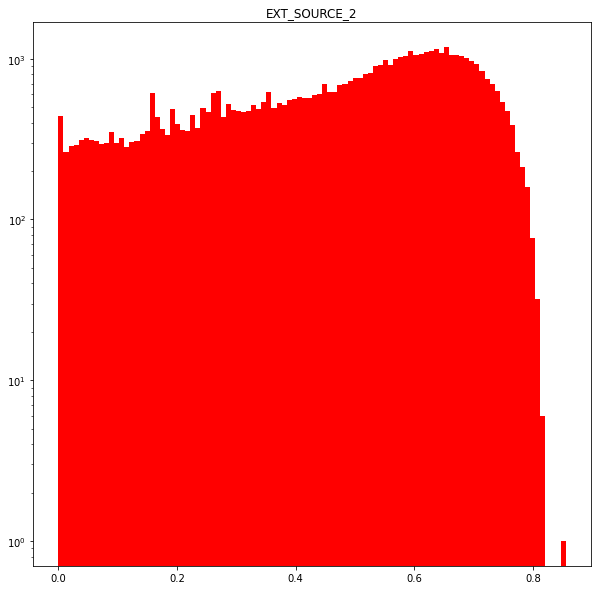

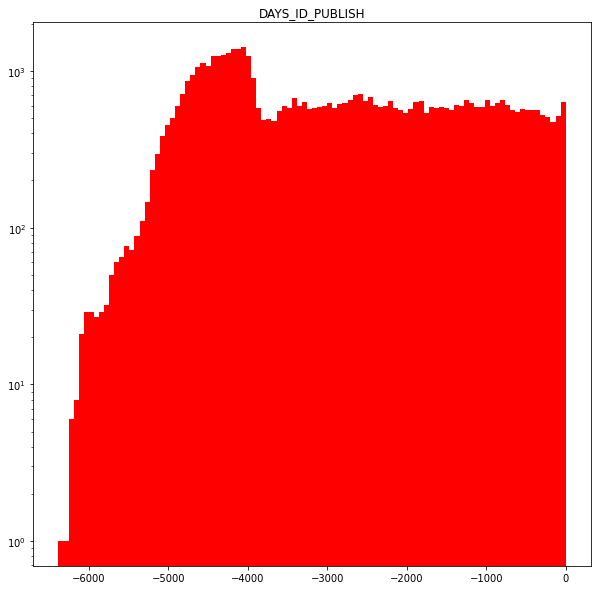

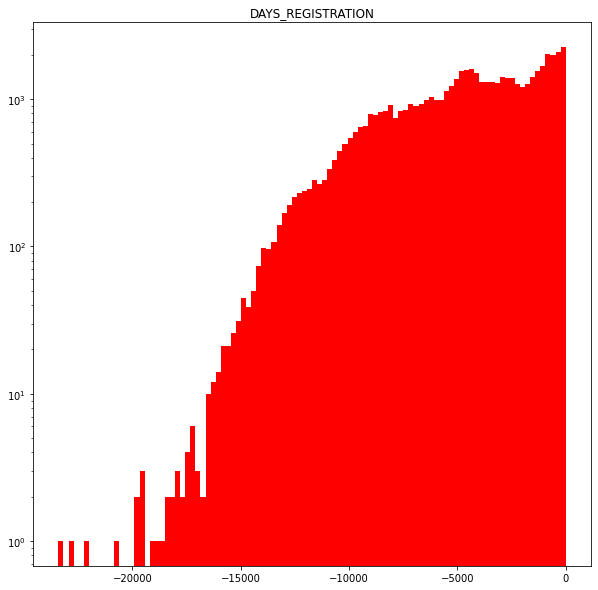

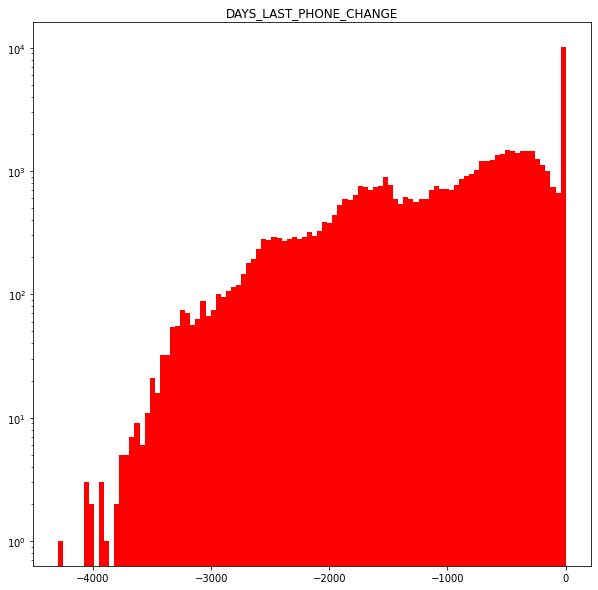

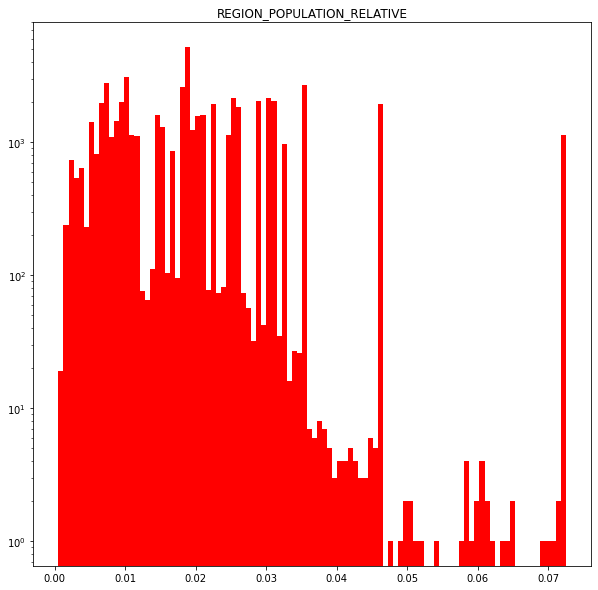

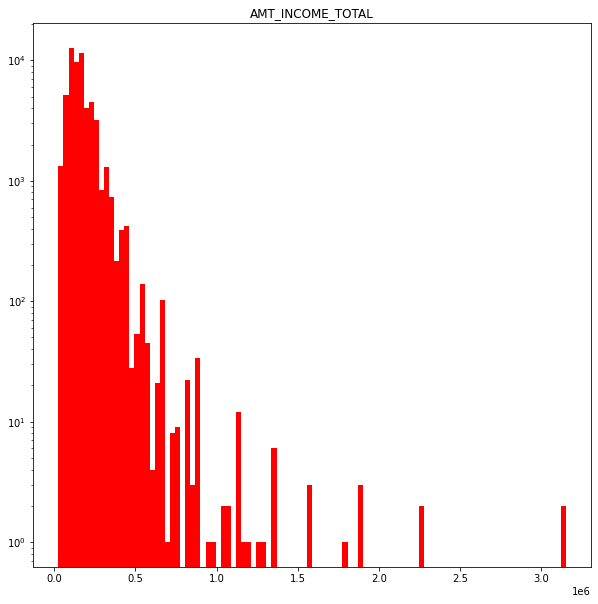

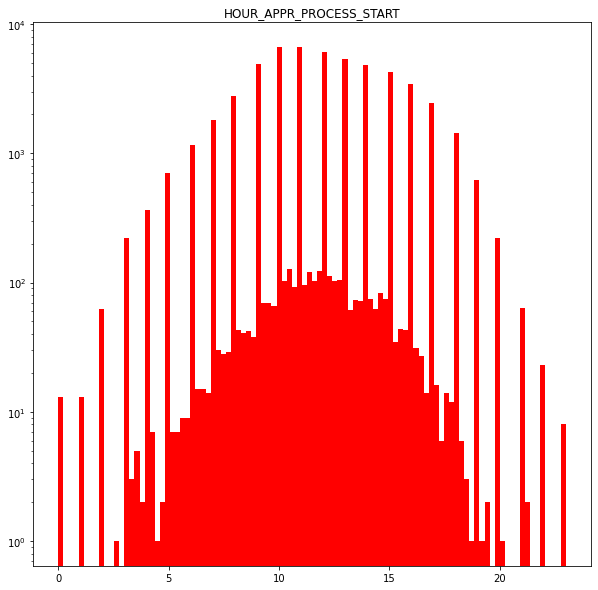

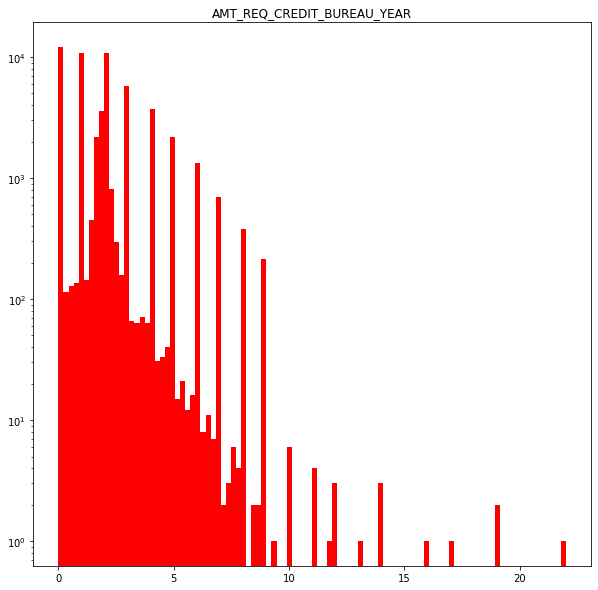

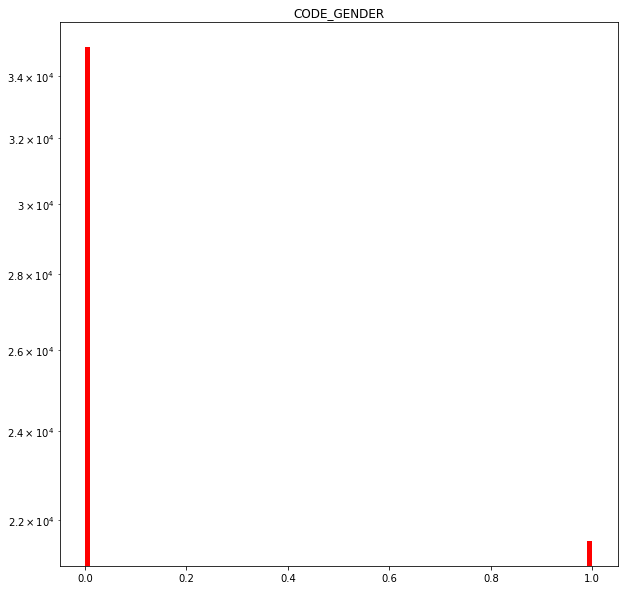

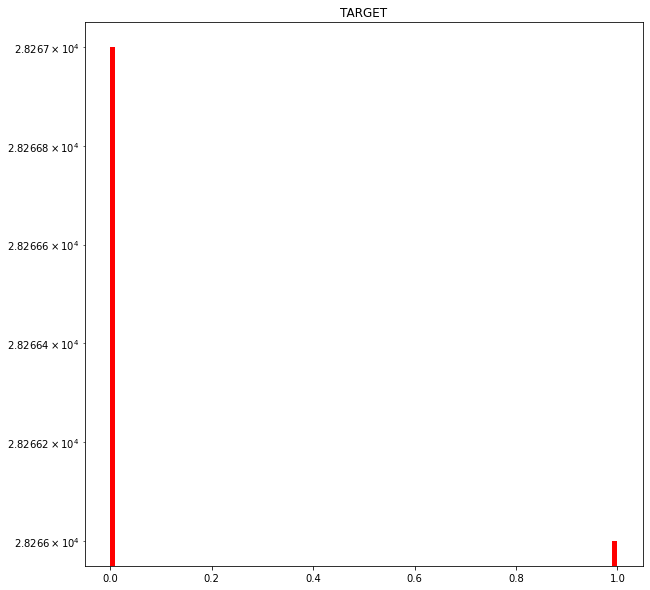

In [178]:
for col in df_imp.columns:
    plt.figure(figsize=(10, 10))
    plt.hist(df_imp[col], bins=100, color='red', zorder=0,log=True)
    plt.title(col)
    plt.show()
plt.close('all')

In [196]:
if not os.path.exists('final_data'):
    os.makedirs('final_data')

cols=df_imp.drop(columns="TARGET").columns

app_test =pd.read_csv('./p7_datas/application_test.csv',sep=',')[cols]
app_test["CODE_GENDER"], _ =pd.factorize(app_test["CODE_GENDER"])

app_test.to_csv(r"final_data/df_test.csv")
df_imp.to_csv(r"final_data/df_train.csv")